In [1]:
import os
os.chdir("../../")

from scripts.utils import *
from scripts.parsing import *
from scripts.evaluate import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Main results

In [3]:
model_renamer = {"lmsys/vicuna-13b-v1.5": "Vicuna", 
                 "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
                 "meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", 
                 "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", 
                 "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
                 "gpt-3.5-turbo-0125": "GPT-3.5", "gpt-4-turbo-2024-04-09": "GPT-4"}

main_results_details = pd.read_json("results/main_results_all_details.json", lines=True)
main_results_stats = pd.read_csv("results/main_results_statistics.csv")

for df in [main_results_details, main_results_stats]:
    df["model"] = df["model"].map(model_renamer)

del df

In [4]:
tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]
benchmarks = ["SST-2", "CoLA", "AGNews", "MRPC", "SNLI", "WiC"]
models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

colors = ["tab:brown", "tab:pink", "tab:green", 
          "tab:orange", "tab:red", "tab:purple", "tab:blue"]
model2color = dict(zip(models, colors))
model2color.update({"Overall": "black"})
task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
              "SelectOne": "tab:green", "SelectAll": "tab:red"}

### 1. Average accuracy of the 7 LLMs on the 4 types of tasks across various task sizes for each benchmark

In [5]:
def get_overall_results_pv(benchmarks):
    overall_results = []
    cols = ["model", "task", "accuracy"]
    tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]

    for task in tasks:
        sub = main_results_stats.copy()[(main_results_stats.task == task) & (main_results_stats.benchmark.isin(benchmarks))]
        overall_results.append(["Overall", task, sub["performance"].mean()])
        
    models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
              "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]
    for model in models:
        sub = main_results_stats.copy()[(main_results_stats.model == model) & (main_results_stats.benchmark.isin(benchmarks))]
        for task in tasks:
            subsub = sub.copy()[sub.task == task]
            acc = subsub["performance"].mean()
            overall_results.append([model, task, acc])

    models =  models + ["Overall"]
    overall_results_df = pd.DataFrame(overall_results, columns=cols)
    overall_results_df = overall_results_df.pivot(index="model", columns="task", values="accuracy")
    overall_results_df = overall_results_df.loc[models]
    overall_results_df = overall_results_df.round(3)
    overall_results_df = overall_results_df * 100
    overall_results_df = overall_results_df.astype(float)
    
    return overall_results_df

In [6]:
all_overall_results_df = get_overall_results_pv(benchmarks)

In [7]:
# new first, old second
all_overall_results_df[tasks]

task,SingleClf,BatchClf,SelectOne,SelectAll
model,,,,
Vicuna,69.1,65.0,17.9,43.2
Mistral 7B,72.8,70.2,31.5,51.5
Mixtral 8x7B,77.5,69.2,38.4,60.1
Llama-3 8B,74.7,72.4,33.0,54.6
Llama-3 70B,79.1,79.3,54.2,70.0
GPT-3.5,75.3,67.3,41.4,63.4
GPT-4,80.2,82.2,65.4,78.0
Overall,75.5,72.3,40.4,60.2


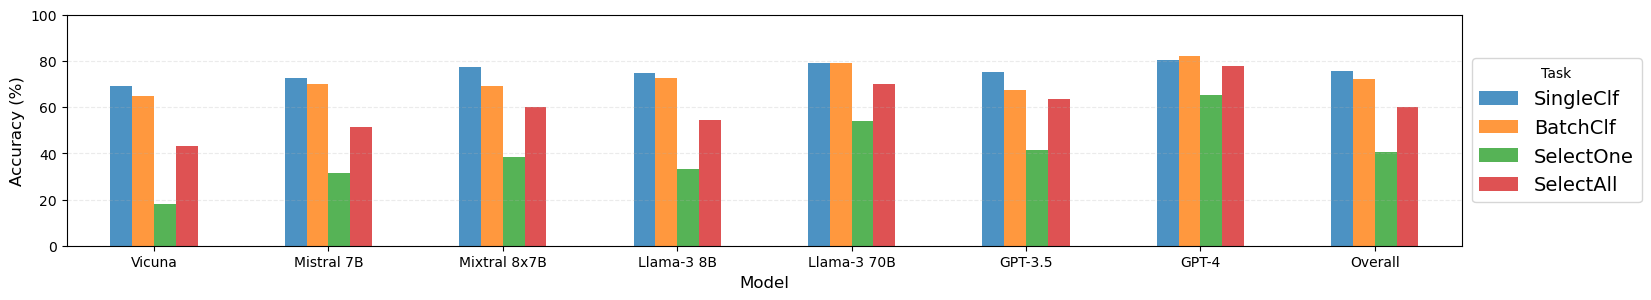

In [9]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(18, 3))
# single_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.4)
all_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.8)
# pair_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.4)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=0)

single_patch = mpatches.Patch(color='tab:blue', label='Single Clf')
batch_patch = mpatches.Patch(color='tab:orange', label='Batch Clf')
index_one_patch = mpatches.Patch(color='tab:green', label='Index Select One Cat')
index_all_patch = mpatches.Patch(color='tab:red', label='Index Select All Cat')

plt.legend(title="Task",loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.ylim(0, 100)
plt.savefig("plots/average_accuracy_on_the_4_tasks_for_the_7_llms.png", bbox_inches='tight', dpi=300)
plt.show()

In [10]:
main_results = []
cols = ["benchmark", "task", "taskSize", "accuracy"]

for benchmark in benchmarks:
    sub = main_results_stats.copy()[main_results_stats.benchmark == benchmark]
    for task in tasks:
        subsub = sub.copy()[sub.task == task]
        for taskSize in sorted(subsub.taskSize.unique()):
            subsubsub = subsub.copy()[subsub.taskSize == taskSize]
            acc = subsubsub["performance"].mean()
            main_results.append([benchmark, task, taskSize, acc])

main_results_df = pd.DataFrame(main_results, columns=cols)
main_results_df_pv = main_results_df.pivot(index=["benchmark", "taskSize"], columns="task", values="accuracy")
main_results_df_pv = main_results_df_pv.loc[benchmarks]
main_results_df_pv = main_results_df_pv.round(3)
main_results_df_pv = main_results_df_pv * 100
main_results_df_pv = main_results_df_pv.astype(float)
main_results_df_pv[tasks].head()

task                SingleClf  BatchClf  SelectOne  SelectAll
benchmark taskSize                                           
SST-2     1              91.4       NaN        NaN        NaN
          5               NaN      91.0       59.7       79.1
          10              NaN      89.8       68.6       81.2
          20              NaN      87.7       66.2       79.2
          50              NaN      89.3       55.1       71.5

In [11]:
mean = lambda ls: sum(ls) / len(ls)
models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

rs = []
cols = ["> 90% SingleClf", "> 80% SingleClf", "> 75% SingleClf"]
difs_90_all = []
difs_80_all = []
difs_75_all = []

for model in models:
    difs_90 = []
    difs_80 = []
    disf_75 = []

    for benchmark in benchmarks:
        sub = main_results_stats.copy()[(main_results_stats.benchmark == benchmark) & 
                                        (main_results_stats.model == model)]
        sc = sub.copy()[sub.task == "SingleClf"].performance.item()
        
        for taskSize in sorted(sub.taskSize.unique())[1:]:
            bc = sub.copy()[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()        
            difs_90.append(bc > sc*0.9)
            difs_80.append(bc > sc*0.8)
            disf_75.append(bc > sc*0.75)

            difs_90_all.append(bc > sc*0.9)
            difs_80_all.append(bc > sc*0.8)
            difs_75_all.append(bc > sc*0.75)
    
    rs.append([mean(difs_90), mean(difs_80), mean(disf_75)])

mean = lambda ls: sum(ls) / len(ls)
rs = [[mean(difs_90_all), mean(difs_80_all), mean(difs_75_all)]] + rs

rs_df = pd.DataFrame(rs, columns=cols).round(3)*100
rs_df.index = models + ["Overall"]
rs_df.head()

,> 90% SingleClf,> 80% SingleClf,> 75% SingleClf
Vicuna,75.6,90.4,95.7
Mistral 7B,79.3,93.1,93.1
Mixtral 8x7B,76.7,83.3,100.0
Llama-3 8B,63.3,83.3,86.7
Llama-3 70B,73.3,90.0,100.0


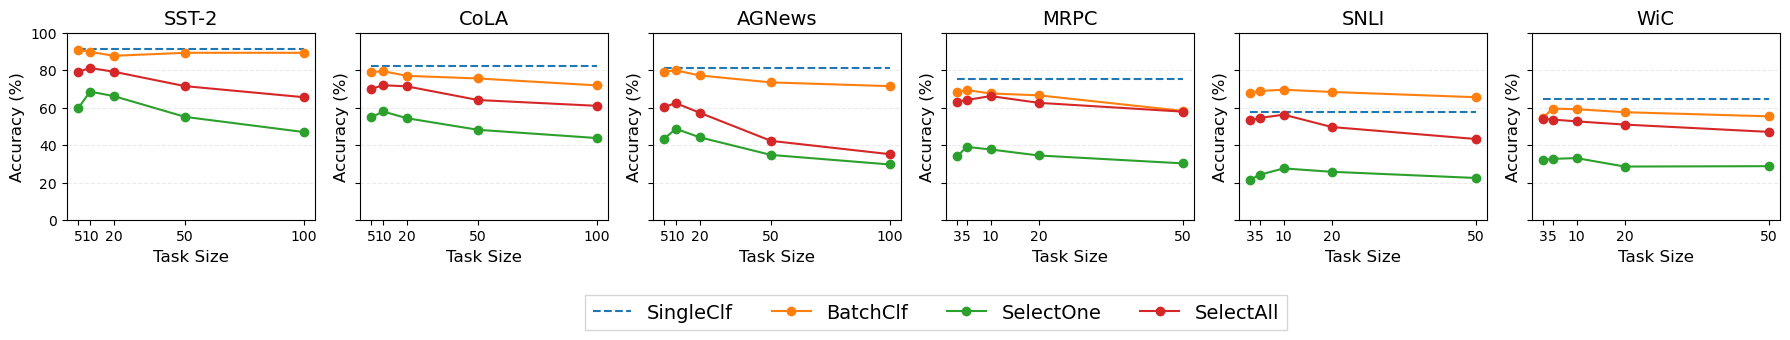

In [12]:
fig, axs = plt.subplots(1, len(benchmarks), figsize=(18, 3), sharey=True)

for i, benchmark in enumerate(benchmarks):
    sub = main_results_df[main_results_df.benchmark == benchmark]
    taskSizes = sorted(sub.taskSize.unique())[1:]
    
    for task in tasks:
        subsub = sub[sub.task == task]

        if task == "SingleClf":
            acc = subsub.accuracy
            axs[i].plot(taskSizes, [round(acc, 3) * 100] * len(taskSizes), label=task, linestyle="--", color=task2color[task])
        else:
            accs = []
            for taskSize in taskSizes:
                acc = subsub[subsub.taskSize == taskSize].accuracy
                accs.append(round(acc, 3) * 100)
                
            axs[i].plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])
        
        axs[i].set_title(benchmark, fontsize=14)
        axs[i].set_xlabel("Task Size", fontsize=12)
        axs[i].set_xticks(taskSizes)
        axs[i].set_ylabel("Accuracy (%)", fontsize=12)
        axs[i].grid(axis='y', linestyle='--', alpha=0.25)
        axs[i].set_ylim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.legend(loc='upper center', bbox_to_anchor=(-2.4, -0.35), fontsize=14, fancybox=False, shadow=False, ncol=8)
plt.savefig("plots/average_accuracy_of_the_7_llms_on_the_4_tasks_across_task_sizes.png", bbox_inches='tight', dpi=300)
plt.show()

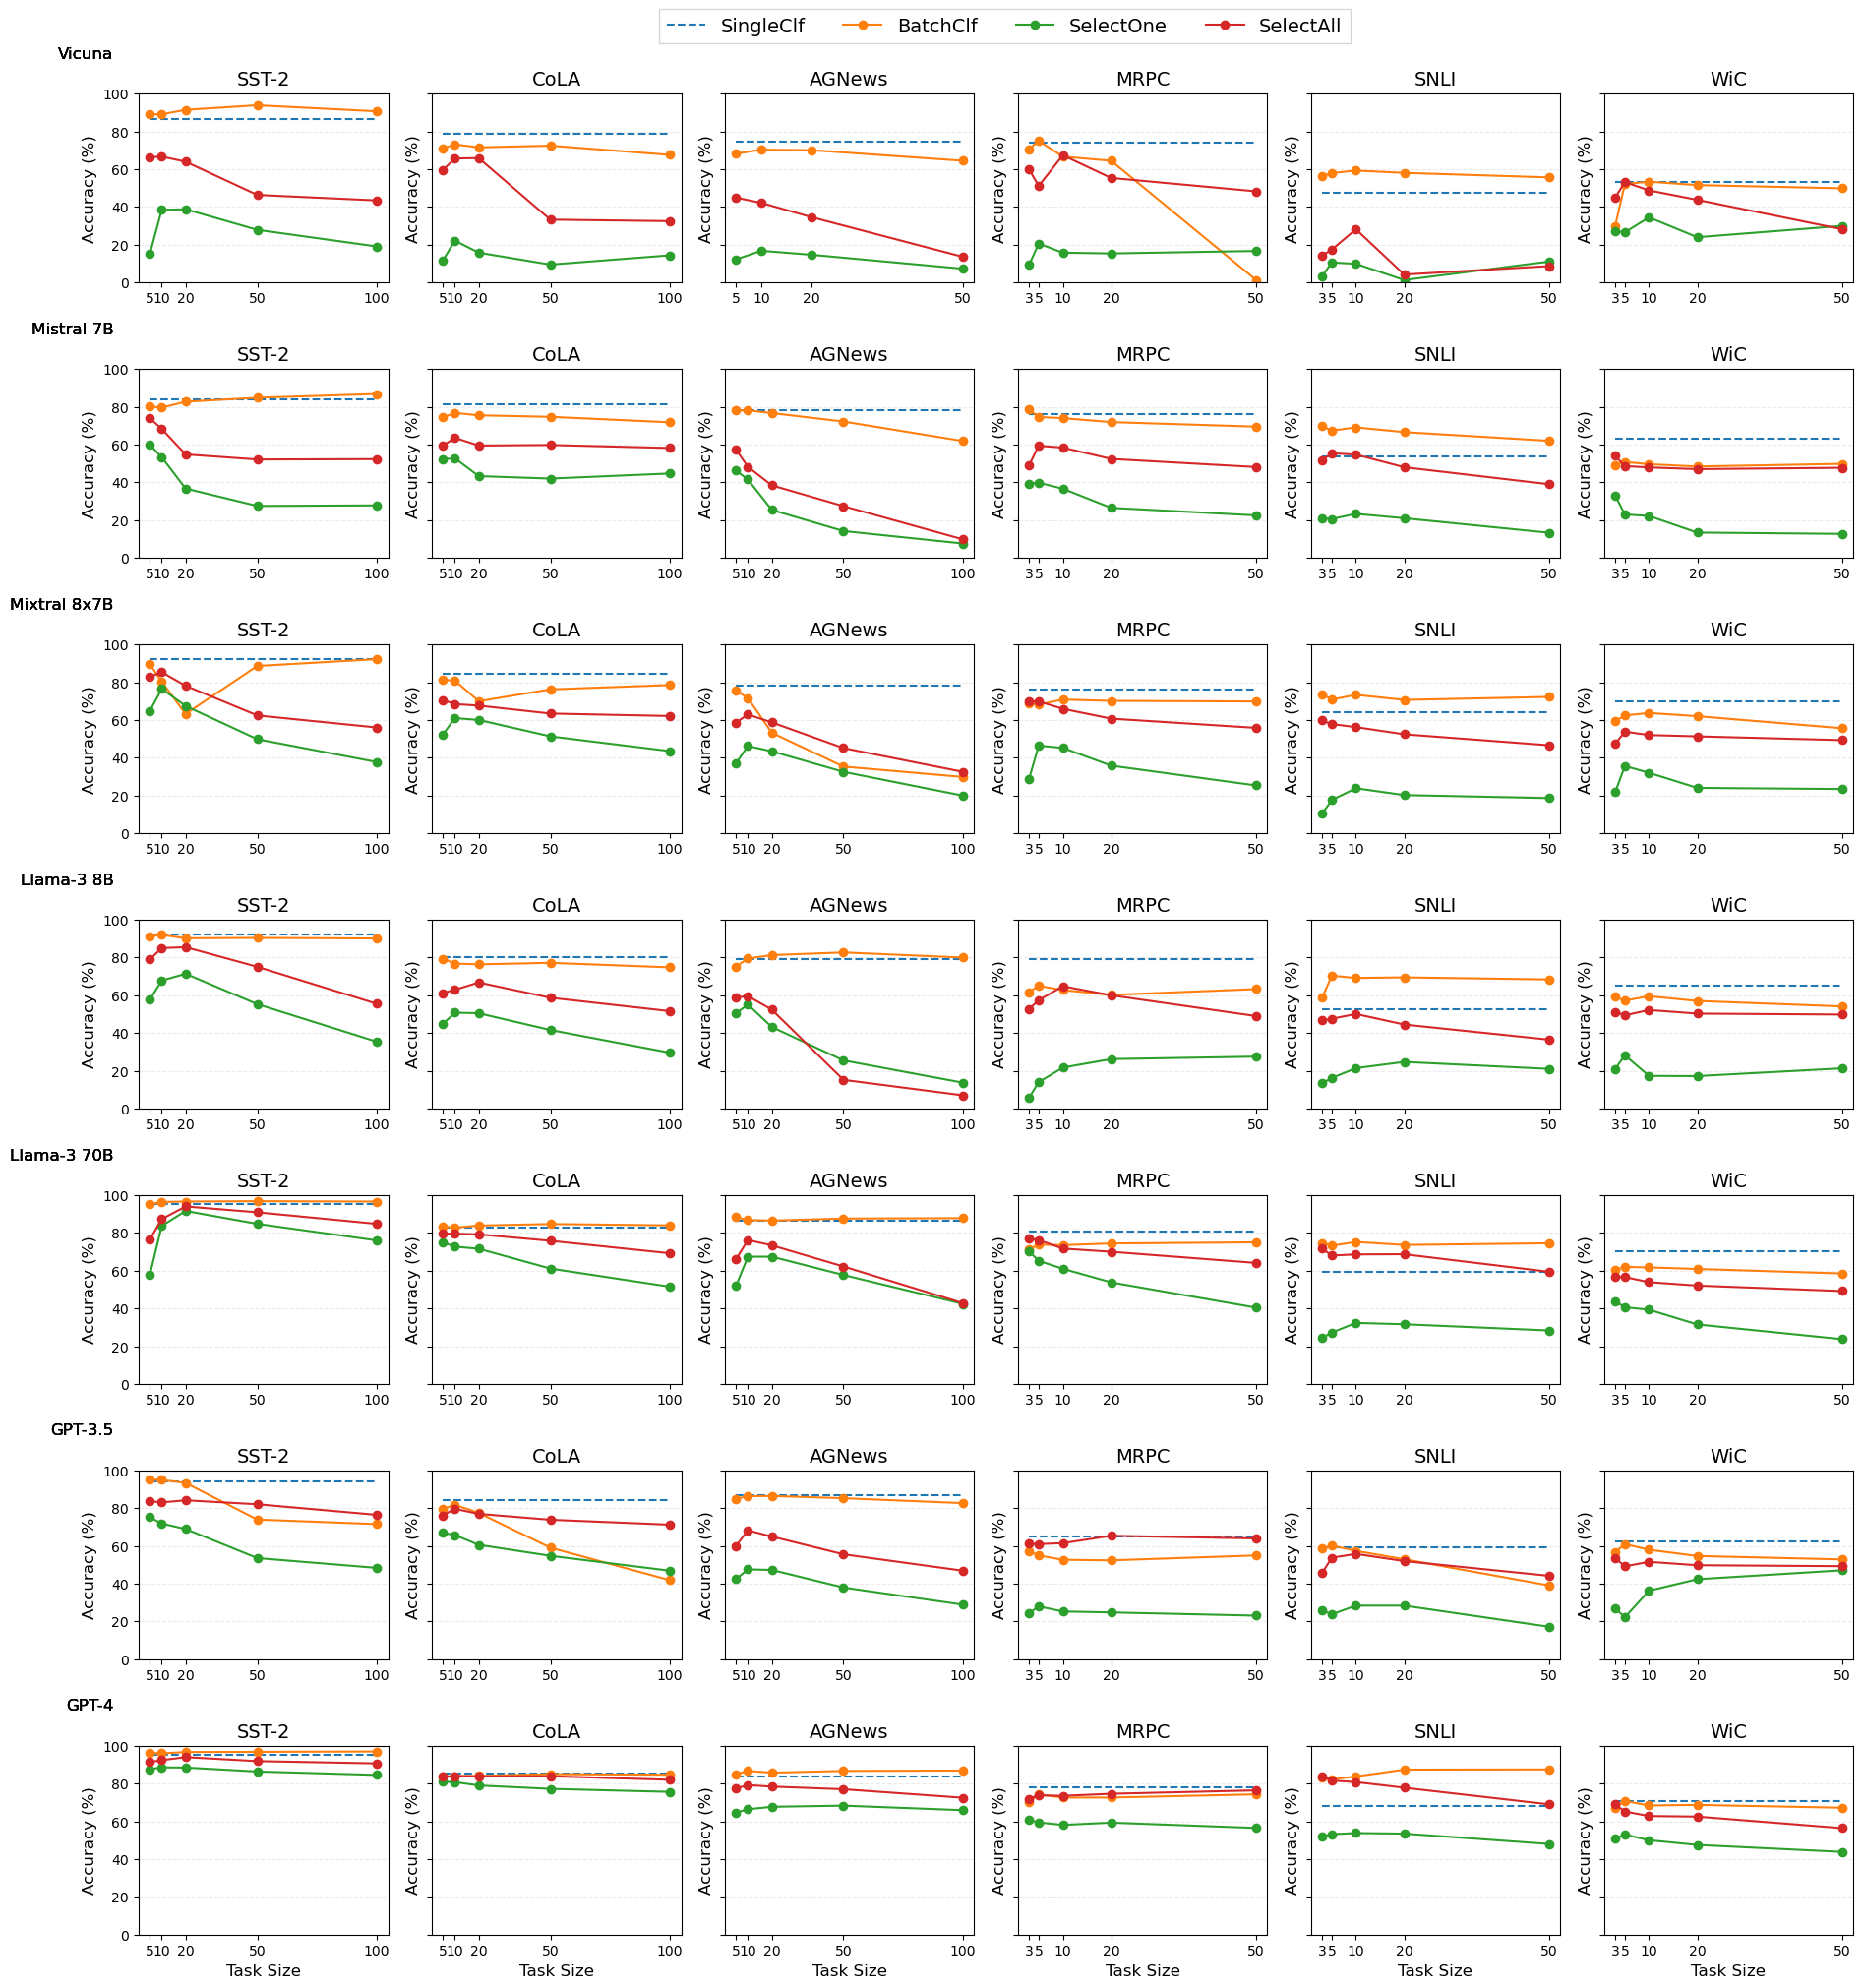

In [14]:
# make a 1x6 grid plots, where each panel is a benchmark, with the taskSize on the x-axis and accuracy on the y-axis.

fig, axs = plt.subplots(len(models), 6, figsize=(19, 21), sharey=True)
benchmarks = ["SST-2", "CoLA", "AGNews", "MRPC", "SNLI", "WiC"]

for j, model in enumerate(models):
    for i, benchmark in enumerate(benchmarks):
        sub = main_results_stats[(main_results_stats.benchmark == benchmark) & 
                                 (main_results_stats.model == model)]
        taskSizes = sorted(sub.taskSize.unique())[1:]
        ax = axs[j][i]
        for task in tasks:
            subsub = sub[sub.task == task]

            if task == "SingleClf":
                acc = subsub.performance
                ax.plot(taskSizes, [round(acc, 3) * 100] * len(taskSizes), 
                        label=task, linestyle="--", color=task2color[task])

            else:
                accs = []
                for taskSize in taskSizes:
                    acc = subsub[subsub.taskSize == taskSize].performance
                    accs.append(round(acc, 3) * 100)
                    
                ax.plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])
            
            ax.set_title(benchmark, fontsize=14)

            if i == 0:
                ax.text(-0.1, 1.25, model, transform=ax.transAxes, 
                        fontsize=12, va='top', ha='right')

            if j == len(models) - 1:
                ax.set_xlabel("Task Size", fontsize=12)
            ax.set_xticks(taskSizes)
            ax.set_ylabel("Accuracy (%)", fontsize=12)
            ax.set_yticks(np.arange(0, 101, 20))
            ax.grid(axis='y', linestyle='--', alpha=0.25)
            ax.set_ylim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.legend(loc='upper center', bbox_to_anchor=(-2.4, 10.25), fontsize=14, fancybox=False, shadow=False, ncol=7)

plt.savefig("plots/full_results.png", bbox_inches='tight', dpi=300)
plt.show()

### 2. Significant testing

In [15]:
main_results = []
cols = ["benchmark", "model", "task", "taskSize", "accuracy"]
non_sc_tasks = ["BatchClf", "SelectOne", "SelectAll"]

for benchmark in benchmarks:
    for model in main_results_stats.model.unique():
        sub = main_results_stats.copy()[(main_results_stats.benchmark == benchmark) & (main_results_stats.model == model)]

        for task in non_sc_tasks:
            subsub = sub.copy()[sub.task == task]
            for taskSize in sorted(subsub.taskSize.unique()):
                subsubsub = subsub.copy()[subsub.taskSize == taskSize]
                acc = subsubsub["performance"].mean()
                main_results.append([benchmark, model, task, taskSize, acc])

main_results_df = pd.DataFrame(main_results, columns=cols)
main_results_df_pv = main_results_df.pivot(index=["benchmark", "model", "taskSize"], columns="task", values="accuracy")
main_results_df_pv = main_results_df_pv.loc[benchmarks]
main_results_df_pv = main_results_df_pv.round(3)
main_results_df_pv = main_results_df_pv * 100
main_results_df_pv = main_results_df_pv.astype(float)
main_results_df_pv[non_sc_tasks]

task                        BatchClf  SelectOne  SelectAll
benchmark model   taskSize                                
SST-2     GPT-3.5 5             95.2       75.2       83.8
                  10            95.0       71.9       83.1
                  20            93.4       69.0       84.2
                  50            74.0       53.6       82.1
                  100           71.6       48.4       76.5
...                              ...        ...        ...
WiC       Vicuna  3             30.0       27.3       45.0
                  5             52.2       26.6       53.2
                  10            53.4       34.5       48.8
                  20            51.6       24.0       43.8
                  50            49.9       30.0       28.2

[209 rows x 3 columns]

In [16]:
gaps = []
cols = ["BatchClf vs SelectOne", "BatchClf vs SelectAll", "SelectOne vs SelectAll"]
multi_question_tasks = ["BatchClf", "SelectOne", "SelectAll"]

for i in range(len(multi_question_tasks)):
    t1 = multi_question_tasks[i]
    for j in range(i+1, len(multi_question_tasks)):
        t2 = multi_question_tasks[j]
        gaps.append(main_results_df_pv[t1] - main_results_df_pv[t2])

In [17]:
gaps_df = pd.DataFrame(zip(*gaps), columns=cols)
stats = gaps_df.describe().loc[["mean", "std"]].round(1)
stats.index = ["MeanDif", "Std"]
stats

,BatchClf vs SelectOne,BatchClf vs SelectAll,SelectOne vs SelectAll
MeanDif,31.9,12.1,-19.9
Std,16.9,15.3,12.0


In [18]:
from scipy.stats import mannwhitneyu
from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

ps = []
ds = []
stats = gaps_df.describe().loc[["mean", "std"]].round(1)
stats.index = ["Mean Acc Dif", "Std Dev"]


for i in range(len(multi_question_tasks)):
    t1 = multi_question_tasks[i]

    for j in range(i+1, len(multi_question_tasks)):
        t2 = multi_question_tasks[j]
        p1 = main_results_df_pv[t1]
        p2 = main_results_df_pv[t2]
        ps.append(mannwhitneyu(p1, p2).pvalue)
        ds.append(cohen_d(p1, p2))

# stats.loc["p value"] = ps
stats.loc["Cohen's d"] = ds
print(stats.round(1).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  BatchClf vs SelectOne &  BatchClf vs SelectAll &  SelectOne vs SelectAll \\
\midrule
Mean Acc Dif &                   31.9 &                   12.1 &                   -19.9 \\
Std Dev      &                   16.9 &                   15.3 &                    12.0 \\
Cohen's d    &                    1.7 &                    0.8 &                    -1.0 \\
\bottomrule
\end{tabular}



/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_28214/2851525374.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.round(1).to_latex())


In [19]:
min(ps)

2.7589589098812023e-41

### 3. SelectOne versus SelectAll

In [20]:
selection_tasks = ["SelectOne", "SelectAll"]
selection_df = main_results_details.copy()[main_results_details.task.isin(selection_tasks)]

In [21]:
select_tasks_comp = []
cols = ["benchmark", "model", "task", "taskSize", 
        "#contradictions", "#nonExcludedMiddles", "perTaskAccu"]

for benchmark in benchmarks:
    for model in models:
        sub = selection_df.copy()[(selection_df.benchmark == benchmark) & (selection_df.model == model)]
        for task in sorted(selection_df.task.unique()):
            subsub = sub.copy()[sub.task == task]
            for taskSize in sorted(subsub.taskSize.unique()):
                subsubsub = subsub.copy()[subsub.taskSize == taskSize]
                contradictions = subsubsub["#contradictions"].mean()
                nonExcludedMiddles = subsubsub["#nonExcludedMiddles"].mean()
                perTaskAccu = subsubsub["perTaskAccu"].mean()
                select_tasks_comp.append([benchmark, model, task, taskSize, contradictions, nonExcludedMiddles, perTaskAccu])

select_tasks_comp_df = pd.DataFrame(select_tasks_comp, columns=cols)
select_tasks_comp_df_pv = select_tasks_comp_df.pivot(index=["benchmark", "model", "taskSize"], columns="task", values=["#contradictions", "#nonExcludedMiddles", "perTaskAccu"])
select_tasks_comp_df_pv = select_tasks_comp_df_pv.loc[benchmarks]
select_tasks_comp_df_pv = select_tasks_comp_df_pv.round(3)
select_tasks_comp_df_pv = select_tasks_comp_df_pv.astype(float)
select_tasks_comp_df_pv

#contradictions           #nonExcludedMiddles  \
task                             SelectAll SelectOne           SelectAll   
benchmark model   taskSize                                                 
SST-2     GPT-3.5 5                   0.00      0.04                0.47   
                  10                  0.00      0.02                1.28   
                  20                  0.00      0.02                2.33   
                  50                  0.01      0.23                5.47   
                  100                 0.03      1.23               11.28   
...                                    ...       ...                 ...   
WiC       Vicuna  3                   0.02      0.04                0.26   
                  5                   0.00      0.27                0.00   
                  10                  0.22      0.14                0.11   
                  20                  2.29      7.95                0.04   
                  50                 21.38      9.24                0.09   

                                     perTaskAccu            
task                       SelectOne   SelectAll SelectOne  
benchmark model   taskSize                                  
SST-2     GPT-3.5 5             1.08       0.838     0.752  
                  10            2.64       0.831     0.719  
                  20            6.04       0.842     0.690  
                  50           22.21       0.821     0.536  
                  100          47.19       0.765     0.484  
...                              ...         ...       ...  
WiC       Vicuna  3             1.36       0.450     0.273  
                  5             2.00       0.532     0.266  
                  10            2.80       0.488     0.345  
                  20            2.32       0.438     0.240  
                  50            9.93       0.282     0.300  

[209 rows x 6 columns]

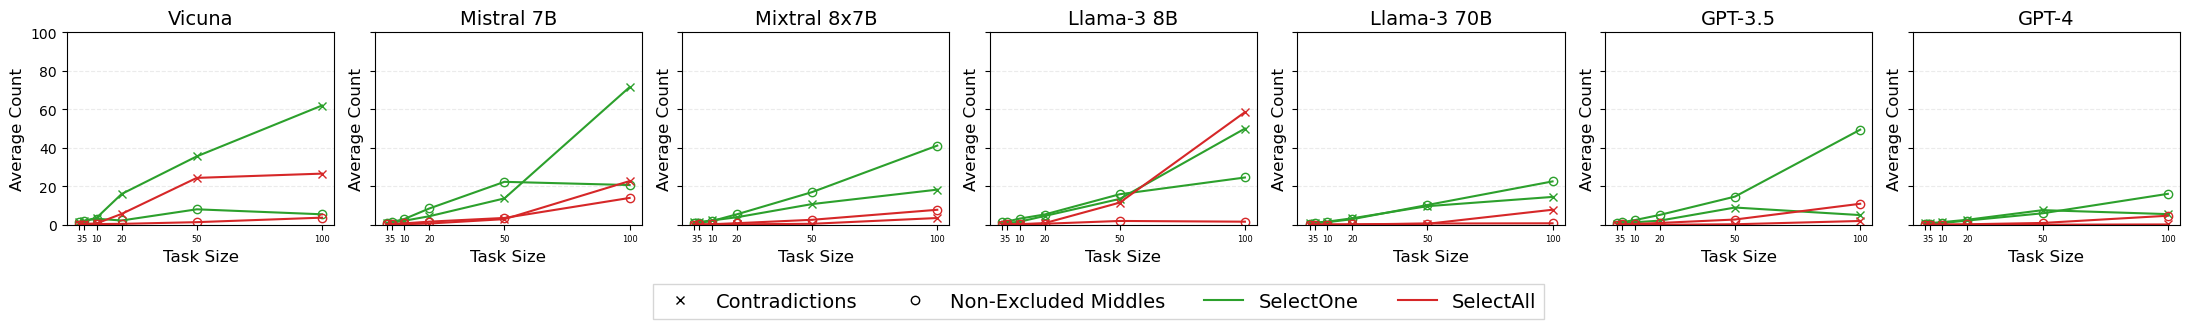

In [24]:
fig, axs = plt.subplots(1, 7, figsize=(22, 3), sharey=True)
metric2marker = {"#contradictions": "x", "#nonExcludedMiddles": "o"}
models = ['Vicuna', 'Mistral 7B', 'Mixtral 8x7B', 'Llama-3 8B', 
          'Llama-3 70B', 'GPT-3.5', 'GPT-4']
task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange",
                "SelectOne": "tab:green", "SelectAll": "tab:red"}

for i, model in enumerate(models):
    sub = selection_df.copy()[selection_df.model == model]
    taskSizes = sorted(sub.taskSize.unique())
    ax = axs[i]

    for task in tasks:
        subsub = sub[sub.task == task]
        for metric in ["#contradictions", "#nonExcludedMiddles"]:
            metric_values = []
            for taskSize in taskSizes:
                metric_value = subsub[subsub.taskSize == taskSize][metric].mean()
                metric_values.append(metric_value)
            
            ax.plot(taskSizes, metric_values, marker=metric2marker[metric], 
                        linestyle="-", color=task2color[task], mfc='none')
            
        
        ax.set_title(model, fontsize=14)
        ax.set_xlabel("Task Size", fontsize=12)
        ax.set_xticks(taskSizes)
        ax.set_xticklabels(ax.get_xticks(), fontsize=6)

        ax.set_ylabel("Average Count", fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.25)
        ax.set_ylim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.plot([], [], 'x', color='black', label='Contradictions')
plt.plot([], [], 'o', color='black', label='Non-Excluded Middles', mfc='none')
plt.plot([], [], 'tab:green', label='SelectOne')
plt.plot([], [], 'tab:red', label='SelectAll')

plt.legend(loc='center left', bbox_to_anchor=(-4.75, -0.4), fontsize=14, fancybox=False, shadow=False, ncol=5)
plt.savefig("plots/selection_tasks_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

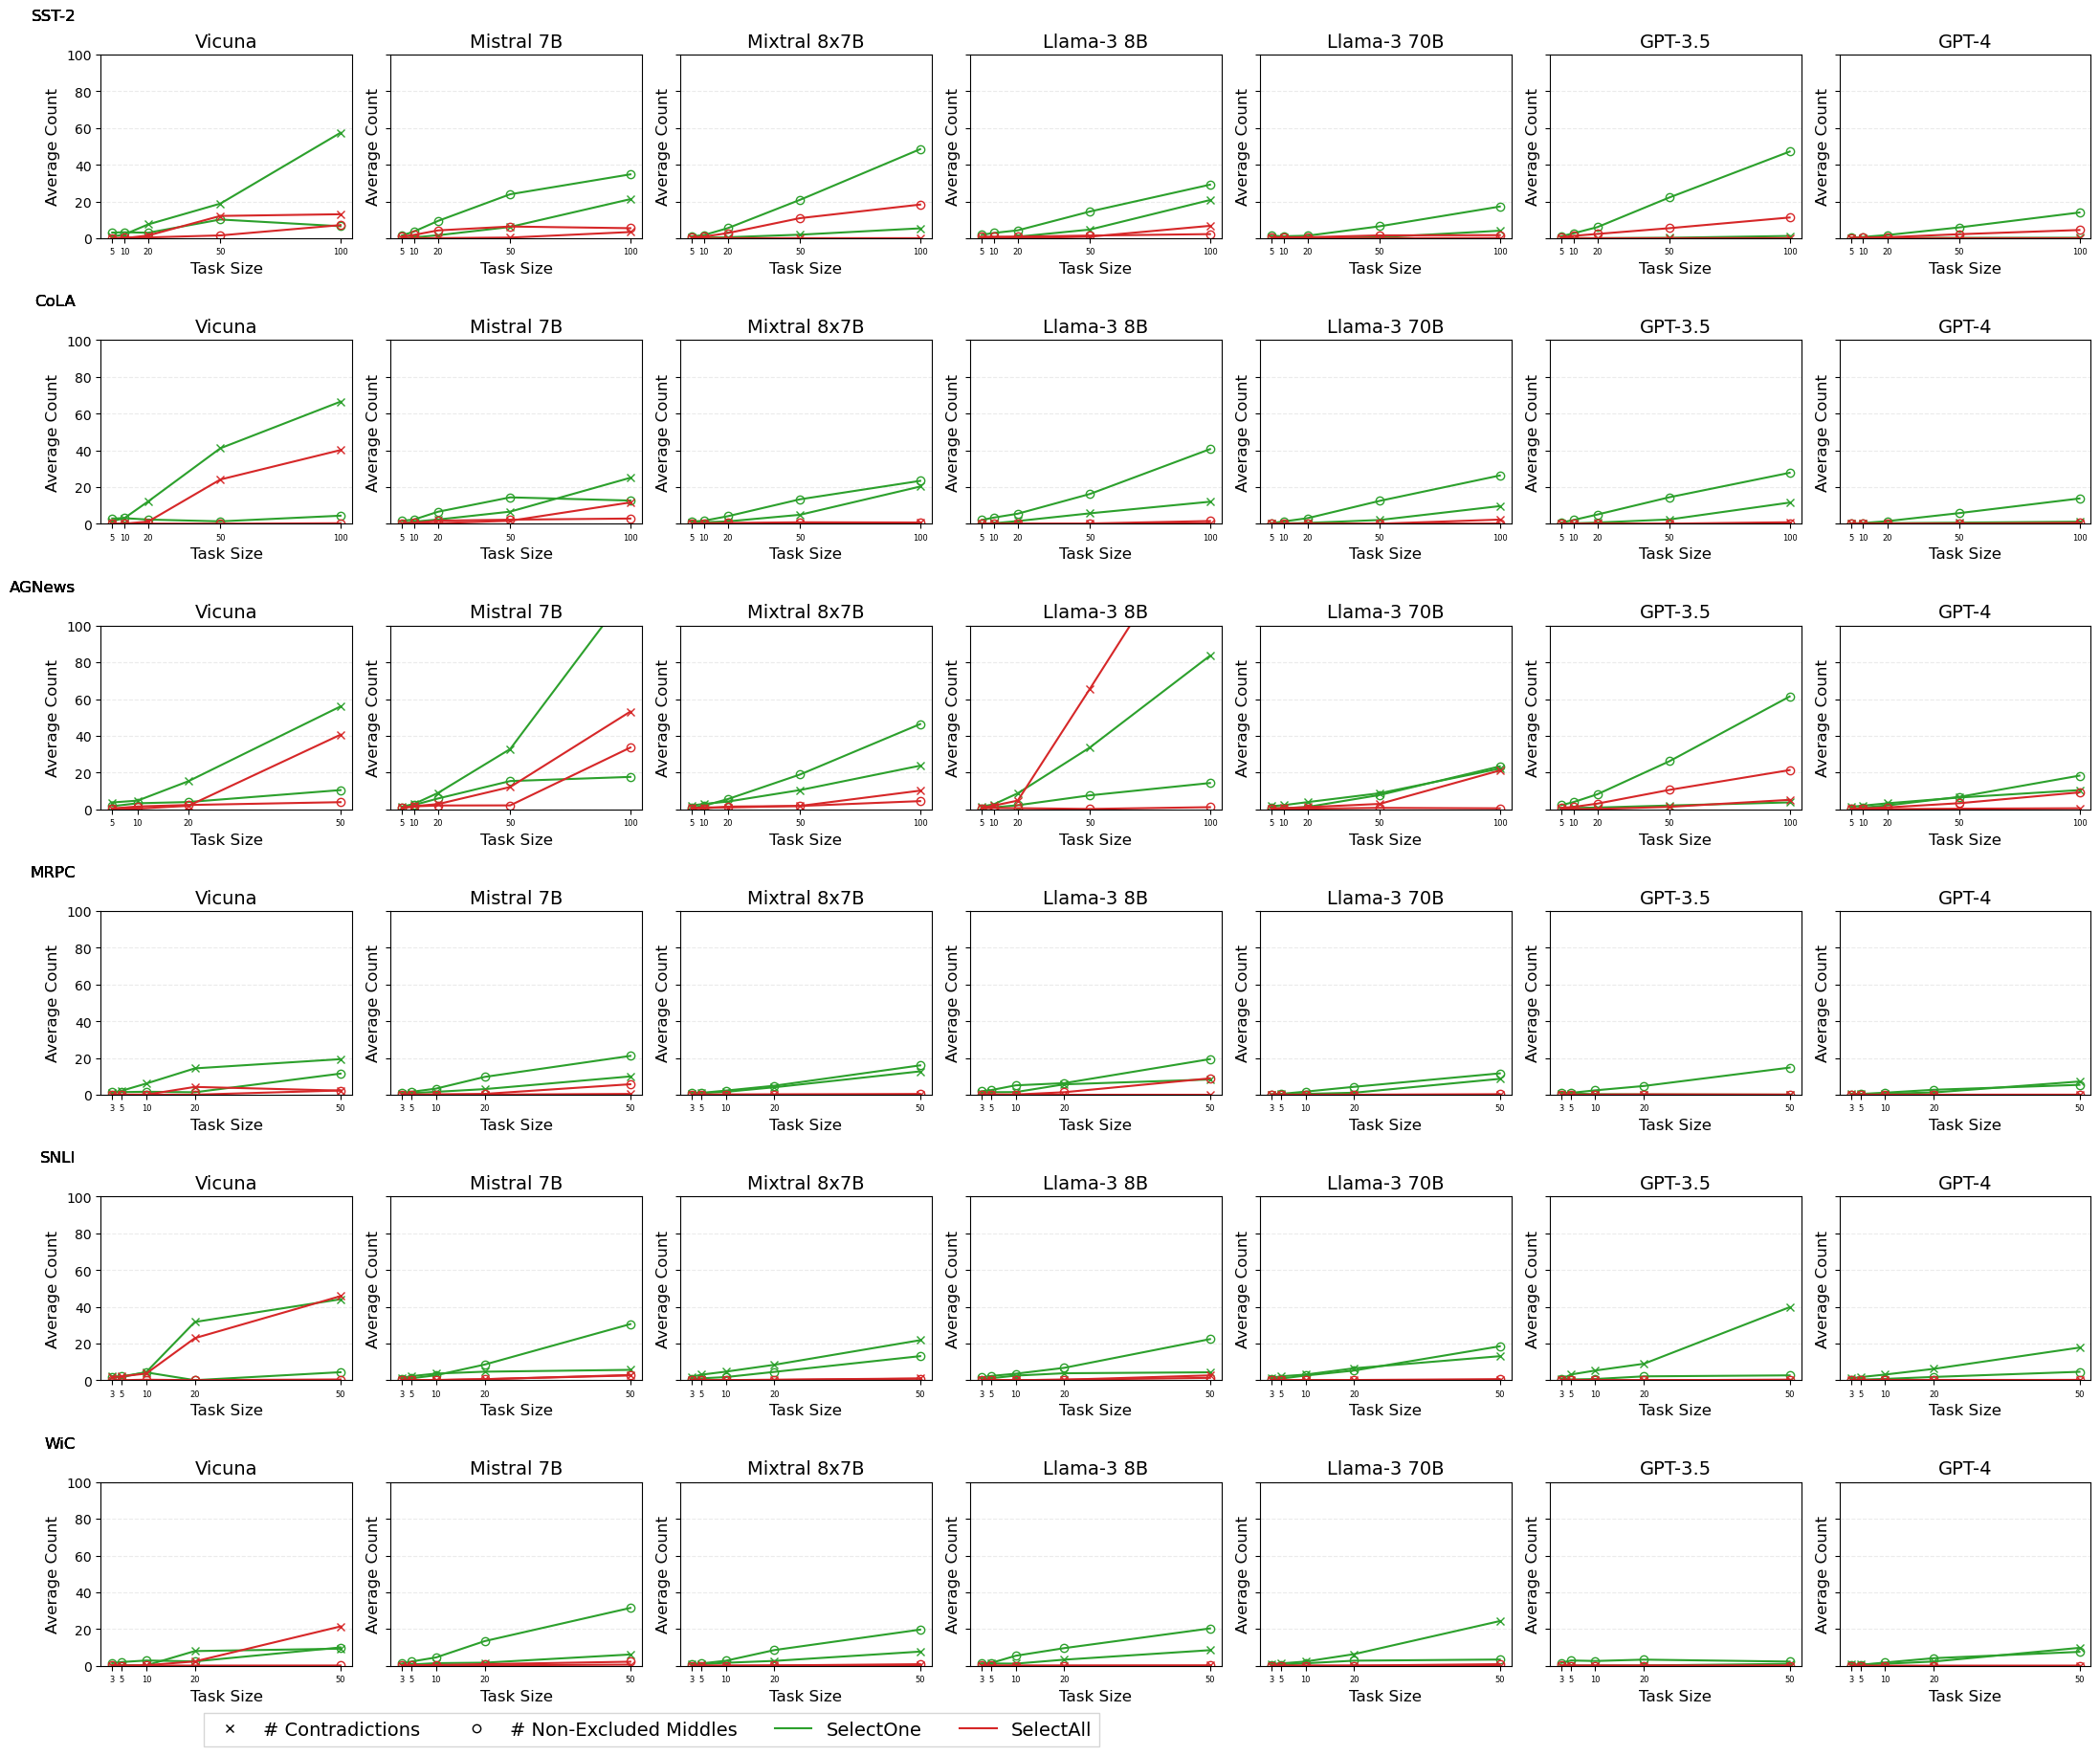

In [28]:
# add a twin y-axis to the plot to show the accuracy of the two tasks with the same model and taskSize in lower alpha

task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", "SelectOne": "tab:green", "SelectAll": "tab:red"}
fig, axs = plt.subplots(6, 7, figsize=(22, 19), sharey=True)
metric2marker = {"#contradictions": "x", "#nonExcludedMiddles": "o"}
models = ['Vicuna', 'Mistral 7B', 'Mixtral 8x7B', 'Llama-3 8B', 
          'Llama-3 70B', 'GPT-3.5', 'GPT-4']

for i, model in enumerate(models):
    for j, benchmark in enumerate(benchmarks):
        sub = selection_df.copy()[(selection_df.model == model) & (selection_df.benchmark == benchmark)]
        taskSizes = sorted(sub.taskSize.unique())
        ax = axs[j][i]

        for task in tasks:
            subsub = sub[sub.task == task]
            for metric in ["#contradictions", "#nonExcludedMiddles"]:
                metric_values = []
                for taskSize in taskSizes:
                    metric_value = subsub[subsub.taskSize == taskSize][metric].mean()
                    metric_values.append(metric_value)
                
                ax.plot(taskSizes, metric_values, marker=metric2marker[metric], 
                            linestyle="-", color=task2color[task], mfc='none')

            ax.set_title(model, fontsize=14)
            ax.set_xlabel("Task Size", fontsize=12)
            ax.set_xticks(taskSizes)
            ax.set_xticklabels(ax.get_xticks(), fontsize=6)

            if i == 0:
                ax.text(-0.1, 1.25, benchmark, transform=ax.transAxes, 
                        fontsize=12, va='top', ha='right')

            ax.set_ylabel("Average Count", fontsize=12)
            ax.grid(axis='y', linestyle='--', alpha=0.25)
            ax.set_ylim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.plot([], [], 'x', color='black', label='# Contradictions')
plt.plot([], [], 'o', color='black', label='# Non-Excluded Middles', mfc='none')
plt.plot([], [], 'tab:green', label='SelectOne')
plt.plot([], [], 'tab:red', label='SelectAll')

plt.legend(loc='center left', bbox_to_anchor=(-6.55, -0.35), fontsize=14, fancybox=False, shadow=False, ncol=5)
# plt.savefig("plots/selection_tasks_comparison_fullResults.png", bbox_inches='tight', dpi=300)
plt.show()

### 4. Cost accuracy ratio

In [31]:
import tiktoken
from transformers import AutoTokenizer
from scripts.llama3_tokenizer import Tokenizer
from mistral_common.tokens.tokenizers.mistral import MistralTokenizer
from mistral_common.protocol.instruct.messages import UserMessage
from mistral_common.tokens.instruct.normalize import InstructRequest


llama_tokenizer = Tokenizer("llama3_tokenizer.model")

def get_tokenizer(model):
    model_renamer_inv = {'Llama-3 70B': 'meta-llama/Llama-3-70b-chat-hf',
                        'Mixtral 8x7B': 'mistralai/Mixtral-8x7B-Instruct-v0.1',
                        'GPT-3.5': 'gpt-3.5-turbo-0125',
                        'Llama-3 8B': 'meta-llama/Llama-3-8b-chat-hf',
                        'Mistral 7B': 'mistralai/Mistral-7B-Instruct-v0.2',
                        'GPT-4': 'gpt-4-turbo-2024-04-09',
                        'Vicuna': 'lmsys/vicuna-13b-v1.5'}
    model = model_renamer_inv[model]

    if "gpt" in model:
        tokenizer = tiktoken.encoding_for_model(model).encode
    
    elif "llama" in model:
        tokenizer = lambda text: llama_tokenizer.encode(text, bos=True, eos=True)
    
    elif "Mistral" in model or "Mixtral" in model:
        model_name = {"mistralai/Mistral-7B-Instruct-v0.2": "open-mistral-7b", 
                      "mistralai/Mixtral-8x7B-Instruct-v0.1": "open-mixtral-8x7b"}[model]
    
        tk = MistralTokenizer.from_model(model_name).instruct_tokenizer.encode_instruct
        tokenizer = lambda text: tk(InstructRequest(messages=[UserMessage(content=text),])).tokens

    elif "vicuna" in model.lower():
        tokenizer = AutoTokenizer.from_pretrained("lmsys/vicuna-13b-v1.5").encode
    
    else:
        raise ValueError(f"Unknown model: {model}")
    
    return tokenizer


def get_num_of_tokens(text, tokenizer):
    return len(tokenizer(text))


conversions = {'Llama-3 70B': {'prompt': 8, 'completion': -1},
               'Mixtral 8x7B': {'prompt': 1, 'completion': -8},
               'GPT-3.5': {'prompt': 7, 'completion': 0},
               'Llama-3 8B': {'prompt': 8, 'completion': -1},
               'Mistral 7B': {'prompt': 1, 'completion': -8},
               'GPT-4': {'prompt': 7, 'completion': 0},
               'Vicuna': {'prompt': 8, 'completion': -1}}

In [32]:
from threading import Thread


main_results_details["prompt_tokens"] = "NotCalculated"
main_results_details["completion_tokens"] = "NotCalculated"

def fill_token_nums(model):
    sub = main_results_details.copy()[main_results_details.model == model]
    tokenizer = get_tokenizer(model)
    print(f"Current model: {model}")

    for col in ["prompt", "completion"]:
        sub[f"{col}_tokens"] = sub[col].apply(lambda x: get_num_of_tokens(x, tokenizer) + conversions[model][col])
        print(f"{model}: {col}_tokens computed for {col}.")
    
    for col in ["prompt", "completion"]:
        for i in sub.index:
            main_results_details.at[i, f"{col}_tokens"] = sub.at[i, f"{col}_tokens"]
        print(f"{model}: {col}_tokens filled for {col}.")

threads = []
for model in main_results_details.model.unique():
    t = Thread(target=fill_token_nums, args=(model,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

Current model: Llama-3 8B
Current model: Mistral 7B
Current model: Llama-3 70B


/Users/wzx/anaconda3/envs/clustering/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Current model: Mixtral 8x7B
Current model: GPT-4Current model: GPT-3.5

Current model: Vicuna
Mixtral 8x7B: prompt_tokens computed for prompt.
Mistral 7B: prompt_tokens computed for prompt.
Mixtral 8x7B: completion_tokens computed for completion.
Mixtral 8x7B: prompt_tokens filled for prompt.
Mixtral 8x7B: completion_tokens filled for completion.
Mistral 7B: completion_tokens computed for completion.
Mistral 7B: prompt_tokens filled for prompt.
Mistral 7B: completion_tokens filled for completion.
Llama-3 8B: prompt_tokens computed for prompt.
Llama-3 70B: prompt_tokens computed for prompt.
GPT-4: prompt_tokens computed for prompt.
GPT-3.5: prompt_tokens computed for prompt.
GPT-3.5: completion_tokens computed for completion.
GPT-3.5: prompt_tokens filled for prompt.Llama-3 70B: completion_tokens computed for completion.

GPT-3.5: completion_tokens filled for completion.
Llama-3 70B: prompt_tokens filled for prompt.
Llama-3 70B: completion_tokens filled for completion.
GPT-4: completion

In [33]:
pricing = {'GPT-4': {'prompt': 10, 'completion': 30},
           'GPT-3.5': {'prompt': 0.5, 'completion': 1.5},
           'Llama-3 8B': {'prompt': 0.2, 'completion': 0.2},
           'Llama-3 70B': {'prompt': 0.9, 'completion': 0.9},
           'Mistral 7B': {'prompt': 0.2, 'completion': 0.2},
           'Mixtral 8x7B': {'prompt': 0.6, 'completion': 0.6},
           'Vicuna': {'prompt': 0.3, 'completion': 0.3}}

In [34]:
def calculate_CAR(length, taskSize, a):
    c = length / taskSize
    return c / a if a > 0 else None


clf_df = main_results_stats.copy()[main_results_stats.task.str.contains("Clf")]

for ix in clf_df.index:
    benchmark = clf_df.at[ix, "benchmark"]
    task = clf_df.at[ix, "task"]
    taskSize = clf_df.at[ix, "taskSize"]
    model = clf_df.at[ix, "model"]
    performance = main_results_stats.at[ix, "performance"]

    sub = main_results_details[(main_results_details.benchmark==benchmark) & 
                               (main_results_details.task==task) & 
                               (main_results_details.taskSize==taskSize) & 
                               (main_results_details.model==model)]
    
    avgInputLen = sub["prompt_tokens"].mean()
    avgOutputLen = sub["completion_tokens"].mean()
    avgInPutOutputLen = avgInputLen + avgOutputLen
    clf_df.at[ix, "avgInputLen"] = avgInputLen
    clf_df.at[ix, "avgOutputLen"] = avgOutputLen
    clf_df.at[ix, "avgInPutOutputLen"] = avgInputLen + avgOutputLen

    clf_df.at[ix, "avgInputLenCAR"] = calculate_CAR(avgInputLen, taskSize, performance)
    clf_df.at[ix, "avgOutputLenCAR"] = calculate_CAR(avgOutputLen, taskSize, performance)
    clf_df.at[ix, "avgInPutOutputLenCAR"] = calculate_CAR(avgInPutOutputLen, taskSize, performance)

    avgInputCost = pricing[model]["prompt"] * avgInputLen
    avgOutputCost = pricing[model]["completion"] * avgOutputLen
    avgInPutOutputCost = avgInputCost + avgOutputCost
    clf_df.at[ix, "avgInputCost"] = avgInputCost
    clf_df.at[ix, "avgOutputCost"] = avgOutputCost
    clf_df.at[ix, "avgInPutOutputCost"] = avgInPutOutputCost

    avgInputCAR = calculate_CAR(avgInputCost, taskSize, performance)
    avgOutputCAR = calculate_CAR(avgOutputCost, taskSize, performance)
    avgInPutOutputCAR = avgInputCAR + avgOutputCAR
    clf_df.at[ix, "avgInputCAR"] = avgInputCAR
    clf_df.at[ix, "avgOutputCAR"] = avgOutputCAR
    clf_df.at[ix, "avgInPutOutputCAR"] = avgInPutOutputCAR

In [35]:
more = []

for benchmark in clf_df.benchmark.unique():
    b_sub = clf_df[clf_df.benchmark == benchmark]
    for taskSize in b_sub.taskSize.unique():
        subsub = b_sub[b_sub.taskSize == taskSize]
        avg_avgInputLen = subsub["avgInputLen"].mean()
        avg_avgOutputLen = subsub["avgOutputLen"].mean()
        avg_avgInPutOutputLen = subsub["avgInPutOutputLen"].mean()
        avg_avgInputLenCAR = subsub["avgInputLenCAR"].mean()
        avg_avgOutputLenCAR = subsub["avgOutputLenCAR"].mean()
        avg_avgInPutOutputLenCAR = subsub["avgInPutOutputLenCAR"].mean()
        avg_avgInputCost = subsub["avgInputCost"].mean()
        avg_avgOutputCost = subsub["avgOutputCost"].mean()
        avg_avgInPutOutputCost = subsub["avgInPutOutputCost"].mean()
        avg_avgInputCAR = subsub["avgInputCAR"].mean()
        avg_avgOutputCAR = subsub["avgOutputCAR"].mean()
        avg_avgInPutOutputCAR = subsub["avgInPutOutputCAR"].mean()

        more.append([benchmark, "-", taskSize, "Overall", "-", "-", "-", "-", 
                     avg_avgInputLen, avg_avgOutputLen, avg_avgInPutOutputLen,
                     avg_avgInputLenCAR, avg_avgOutputLenCAR, avg_avgInPutOutputLenCAR, 
                     avg_avgInputCost, avg_avgOutputCost, avg_avgInPutOutputCost,
                     avg_avgInputCAR, avg_avgOutputCAR, avg_avgInPutOutputCAR])

more = pd.DataFrame(more, columns=clf_df.columns)
clf_df = pd.concat([clf_df, more])

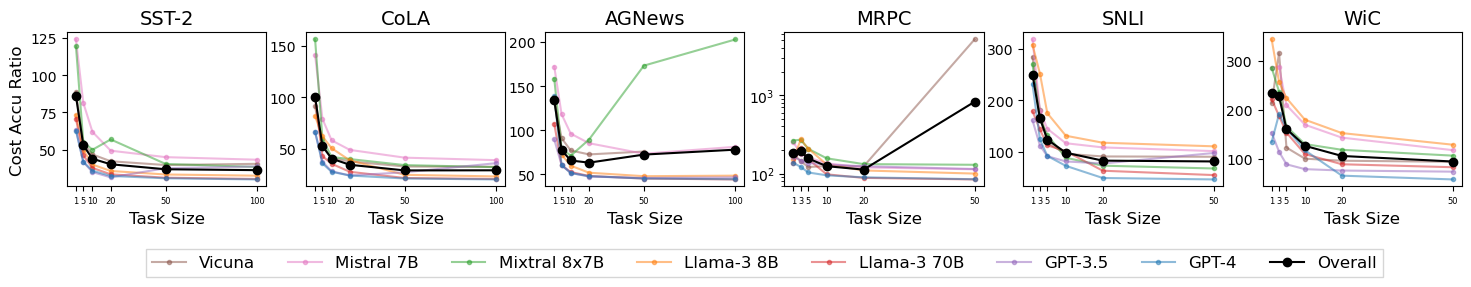

In [36]:
fig, axs = plt.subplots(1, 6, figsize=(18, 2))

for i, benchmark in enumerate(benchmarks):
    ax = axs[i]

    for model in models + ["Overall"]:
        sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
        ratios = []

        taskSizes = sorted(sub.taskSize.unique())

        for taskSize in taskSizes:
            subsub = sub[sub.taskSize == taskSize]
            ratios.append(subsub.avgInPutOutputLenCAR.mean())

        if model not in ["Overall"]:
            ax.plot(taskSizes, ratios, color=model2color[model], label=model, linestyle="-", marker=".", alpha=0.5)
        else:
            ax.plot(taskSizes, ratios, color=model2color[model], label=model, linestyle="-", marker="o", alpha=1)

        ax.set_xlabel("Task Size", fontsize=12)

        if i == 0:
            ax.set_ylabel("Cost Accu Ratio", fontsize=12)
        
        if benchmark == "MRPC":
            ax.set_yscale('log')

        ax.set_title(benchmark, fontsize=14)
        ax.set_xticks(taskSizes)
        ax.set_xticklabels(ax.get_xticks(), fontsize=6)


plt.legend(loc='upper center', bbox_to_anchor=(-2.5, -0.35), fontsize=12, fancybox=False, shadow=False, ncol=8)
plt.savefig("plots/llm_cost_accu_ratio.png", bbox_inches='tight', dpi=300)
plt.show()

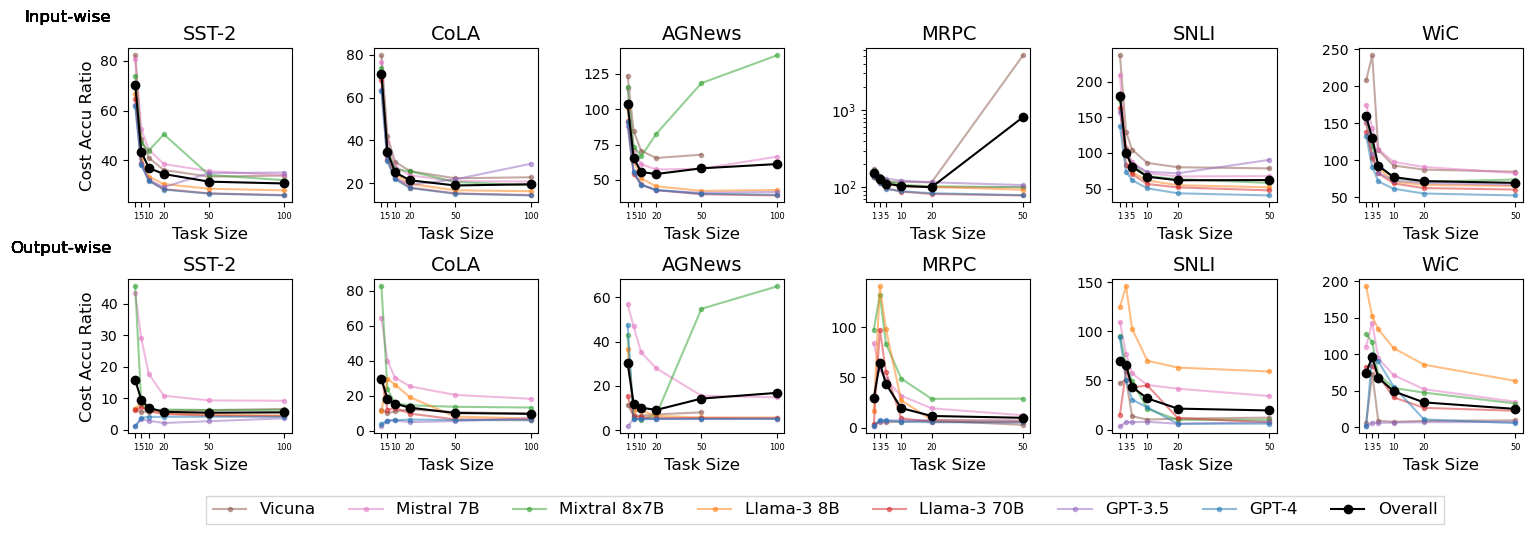

In [37]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5))
# increase the vertical space between the plots
fig.subplots_adjust(hspace=0.5)
# increase the horizontal space between the plots
fig.subplots_adjust(wspace=0.5)

for j, car in enumerate(["avgInputLenCAR", "avgOutputLenCAR"]):

    for i, benchmark in enumerate(benchmarks):
        ax = axs[j][i]

        for model in models + ["Overall"]:
            sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
            ratios = []

            taskSizes = sorted(sub.taskSize.unique())

            for taskSize in taskSizes:
                subsub = sub[sub.taskSize == taskSize]
                ratios.append(subsub[car].mean())

            if model not in ["Overall"]:
                ax.plot(taskSizes, ratios, color=model2color[model], label=model, linestyle="-", marker=".", alpha=0.5)
            else:
                ax.plot(taskSizes, ratios, color=model2color[model], label=model, linestyle="-", marker="o", alpha=1)

            ax.set_xlabel("Task Size", fontsize=12)

            if i == 0:
                ax.set_ylabel("Cost Accu Ratio", fontsize=12)
            
            if j == 0 and benchmark == "MRPC":
                ax.set_yscale('log')

            if j ==0 and i == 0:
                ax.text(-0.1, 1.25, "Input-wise", transform=ax.transAxes, 
                        fontsize=12, va='top', ha='right')
                
            elif j ==1 and i == 0:
                ax.text(-0.1, 1.25, "Output-wise", transform=ax.transAxes, 
                        fontsize=12, va='top', ha='right')
            

            ax.set_title(benchmark, fontsize=14)
            ax.set_xticks(taskSizes)
            ax.set_xticklabels(ax.get_xticks(), fontsize=6)

plt.legend(loc='upper center', bbox_to_anchor=(-3.25, -0.35), fontsize=12, fancybox=False, shadow=False, ncol=8)
plt.savefig("plots/llm_cost_accu_ratio_input_output.png", bbox_inches='tight', dpi=300)
plt.show()

In [38]:
clf_df.head()

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance,avgInputLen,avgOutputLen,avgInPutOutputLen,avgInputLenCAR,avgOutputLenCAR,avgInPutOutputLenCAR,avgInputCost,avgOutputCost,avgInPutOutputCost,avgInputCAR,avgOutputCAR,avgInPutOutputCAR
0,SST-2,SingleClf,1,Llama-3 70B,False,0,0.996156,0.953322,61.592532,5.866008,67.458539,64.608295,6.153226,70.761521,55.433278,5.279407,60.712685,58.147465,5.537903,63.685369
1,SST-2,SingleClf,1,Mixtral 8x7B,False,0,0.998902,0.919824,67.918177,41.820977,109.739154,73.838209,45.466269,119.304478,40.750906,25.092586,65.843493,44.302925,27.279761,71.582687
2,SST-2,SingleClf,1,GPT-3.5,False,0,0.995058,0.940143,58.600769,1.000000,59.600769,62.331776,1.063668,63.395444,29.300384,1.500000,30.800384,31.165888,1.595502,32.761390
3,SST-2,SingleClf,1,Llama-3 8B,False,0,0.98737,0.923119,61.592532,6.012630,67.605162,66.722189,6.513385,73.235574,12.318506,1.202526,13.521032,13.344438,1.302677,14.647115
4,SST-2,SingleClf,1,Mistral 7B,False,0,0.990115,0.842394,67.918177,36.503569,104.421746,80.625163,43.333116,123.958279,13.583635,7.300714,20.884349,16.125033,8.666623,24.791656


In [39]:
savings = []
cols = benchmarks
threshold = 0.95

for model in models:
    sub_savings = []
    for benchmark in benchmarks:
        sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
        sc = sub[sub.task == "SingleClf"].performance.item()
        sc_avgInPutOutputCost = sub[sub.task == "SingleClf"].avgInPutOutputCost.item()

        for taskSize in sorted(sub.taskSize.unique())[1:]:
            bc = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()

            if bc > sc * threshold:
                bc_avgInPutOutputCost = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].avgInPutOutputCost.item() / taskSize
        sub_savings.append((sc_avgInPutOutputCost - bc_avgInPutOutputCost) / sc_avgInPutOutputCost)
    savings.append(sub_savings)

savings_df = pd.DataFrame(savings, columns=cols)
savings_df.index = models
savings_df

,SST-2,CoLA,AGNews,MRPC,SNLI,WiC
Vicuna,0.521227,0.489319,0.635824,0.306689,0.624563,0.560778
Mistral 7B,0.640413,0.673274,0.515770,0.475838,0.631192,0.650260
Mixtral 8x7B,0.677361,0.741543,0.516845,0.701136,0.718217,0.755074
Llama-3 8B,0.566447,0.707416,0.641881,0.681780,0.534164,0.660104
Llama-3 70B,0.565490,0.787602,0.581367,0.648938,0.613185,0.737356
GPT-3.5,0.458456,0.451505,0.409472,0.559837,0.438506,0.363738
GPT-4,0.399954,0.569115,0.758243,0.346941,0.820047,0.378609


In [40]:
for ix in savings_df.index:
    savings_df.at[ix, "All"] = savings_df.loc[ix].mean()

savings_df = savings_df.round(3) * 100
savings_df

,SST-2,CoLA,AGNews,MRPC,SNLI,WiC,All
Vicuna,52.1,48.9,63.6,30.7,62.5,56.1,52.3
Mistral 7B,64.0,67.3,51.6,47.6,63.1,65.0,59.8
Mixtral 8x7B,67.7,74.2,51.7,70.1,71.8,75.5,68.5
Llama-3 8B,56.6,70.7,64.2,68.2,53.4,66.0,63.2
Llama-3 70B,56.5,78.8,58.1,64.9,61.3,73.7,65.6
GPT-3.5,45.8,45.2,40.9,56.0,43.9,36.4,44.7
GPT-4,40.0,56.9,75.8,34.7,82.0,37.9,54.5


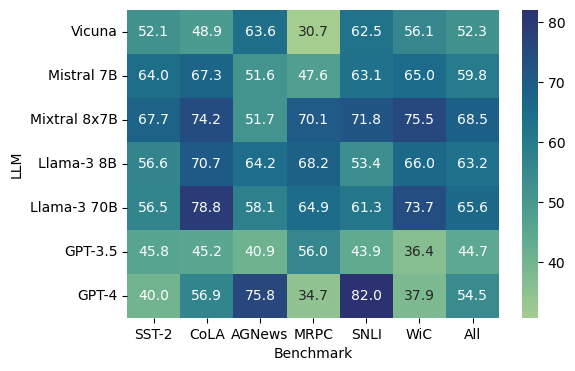

In [98]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.heatmap(savings_df, annot=True, fmt=".1f", cmap="crest", ax=ax)
ax.set_ylabel("LLM")
ax.set_xlabel("Benchmark")
plt.savefig("plots/llm_best_savings.png", bbox_inches='tight', dpi=300)
plt.show()

### 4. Positional errors

In [42]:
from collections import Counter
from scipy.stats import chisquare

def get_errors(answers, preds, pos_only=False):
    if preds == "CANNOT_PARSE":
        preds = []
    
    if len(preds) < len(answers):
        preds = preds + [""] * (len(answers) - len(preds))
    
    errors = []
    if pos_only:
        for ix, (a, p) in enumerate(zip(answers, preds)):
            if a != p:
                errors.append(ix+1)
    else:
        for a, p in zip(answers, preds):
            if a != p:
                errors.append(a)
    
    return errors 


def get_errors_from_df(df, pos_only=False):
    errors = []
    for _, row in df.iterrows():
        errors.extend(get_errors(row["answer"], 
                                 row["parsed"], pos_only))
    return errors


def get_error_distribution(errors, pos_only=False):
    error_counts = Counter(errors)

    if pos_only:
        error_counts = {k: v for k, v in sorted(error_counts.items(), key=lambda item: item[0])}
    else:
        error_counts = {k: v for k, v in sorted(error_counts.items(), key=lambda item: item[1])}
    total = sum(error_counts.values())
    error_counts = {k: v/total for k, v in error_counts.items()}
    error_counts["Total"] = total
    return error_counts


def do_a_chisquare_test(expected: dict, observed: dict):
    expected = expected.copy()
    observed = observed.copy()

    f_exp, f_obs = [], []

    for key in expected.keys():
        if key == "Total":
            continue 
    
        if key not in observed:
            observed[key] = 0
        
        f_exp.append(expected[key])
        f_obs.append(observed[key])
    
    return chisquare(f_obs=f_obs, f_exp=f_exp).pvalue

In [43]:
error_pos_distributions = []
models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]
cols = ["benchmark", "model", "taskSize", "performance", "errorDistribution"]


for benchmark in benchmarks:
    sub = main_results_details[(main_results_details.benchmark == benchmark) & 
                               (main_results_details.task == "BatchClf") &
                               (main_results_details.perTaskAccu < 1.0) ]

    for model in models:
        subsub = sub[sub.model == model]

        for taskSize in sorted(subsub.taskSize.unique()):
            subsubsub = subsub[subsub.taskSize == taskSize]

            performance = main_results_stats[(main_results_stats.benchmark == benchmark) & 
                                             (main_results_stats.model == model) & 
                                             (main_results_stats.taskSize == taskSize)].performance.values[0]


            answers = subsubsub["answer"].to_list()
            preds = subsubsub["parsed"].to_list()
            errors = get_errors_from_df(subsubsub, pos_only=True)
            error_dist = get_error_distribution(errors, pos_only=True)            
            error_pos_distributions.append([benchmark, model, taskSize, performance, error_dist])


error_pos_distributions = pd.DataFrame(error_pos_distributions, columns=cols)
error_pos_distributions

,benchmark,model,taskSize,performance,errorDistribution
0,SST-2,Vicuna,5,0.8920,"{1: 0.18518518518518517, 2: 0.2777777777777778..."
1,SST-2,Vicuna,10,0.8910,"{1: 0.11926605504587157, 2: 0.1284403669724770..."
2,SST-2,Vicuna,20,0.9150,"{1: 0.07647058823529412, 2: 0.0823529411764705..."
3,SST-2,Vicuna,50,0.9388,"{1: 0.042483660130718956, 2: 0.022875816993464..."
4,SST-2,Vicuna,100,0.9070,"{1: 0.030107526881720432, 2: 0.010752688172043..."
...,...,...,...,...,...
204,WiC,GPT-4,3,0.6700,"{1: 0.31313131313131315, 2: 0.3333333333333333..."
205,WiC,GPT-4,5,0.7080,"{1: 0.2054794520547945, 2: 0.1643835616438356,..."
206,WiC,GPT-4,10,0.6840,"{1: 0.11708860759493671, 2: 0.1012658227848101..."
207,WiC,GPT-4,20,0.6875,"{1: 0.0624, 2: 0.048, 3: 0.0656, 4: 0.0416, 5:..."


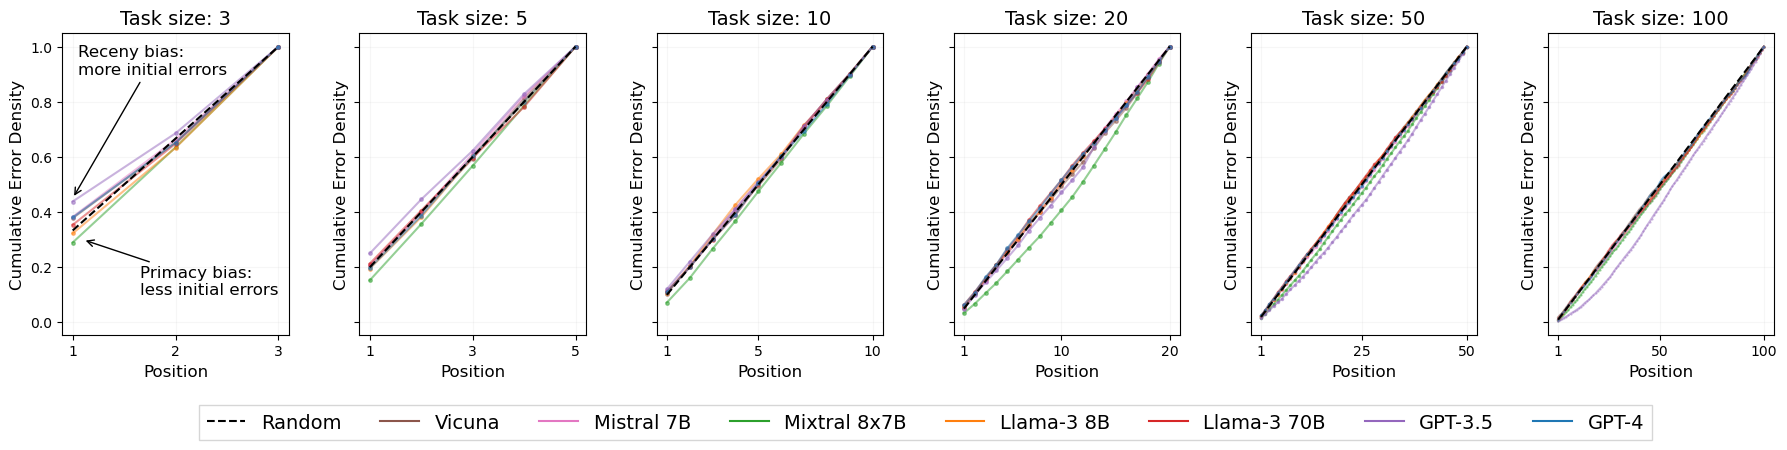

In [46]:
fig, axs = plt.subplots(1, 6, figsize=(18, 4), sharey=True)

# put each sub plot away from each other
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, taskSize in enumerate([3, 5, 10, 20, 50, 100]):
    ax = axs[i]
    sub = error_pos_distributions[error_pos_distributions.taskSize == taskSize]

    for model in models:

        subsub = sub[sub.model == model]
        xs = list(range(1, taskSize+1))
        ys = []
        prev_y = 0
        for x in xs:
            summ = 0
            for errorDist in subsub["errorDistribution"]:
                assert sum(errorDist.values()) == (1 + errorDist["Total"])

                summ += errorDist.get(x, 0)
            
            y = summ / len(subsub) + prev_y
            prev_y = y
            ys.append(y)

        if taskSize <= 20:
            markersize = 5
        elif taskSize == 50:
            markersize = 3
        else:
            markersize = 1
        ax.plot(xs, ys, color=model2color[model], linestyle="-", 
                    marker=".", markersize=markersize, alpha=0.5)
    
    
    ax.plot([1, taskSize], [1/taskSize, 1], label="Random", color="black", linestyle="--",)
    # ax.margins(x=0.1)
    ax.set_title(f"Task size: {taskSize}", fontsize=14)
    ax.set_xlabel("Position", fontsize=12)
    ax.set_ylabel("Cumulative Error Density", fontsize=12)
    

    if i == 0:
        ax.annotate('Receny bias:\nmore initial errors', xy=(1, 0.45), xytext=(1.05, 0.9),
            arrowprops=dict(arrowstyle="->", facecolor='black'), fontsize=12)
        
        ax.annotate('Primacy bias:\nless initial errors', xy=(1.1, 0.3), xytext=(1.65, 0.1),
            arrowprops=dict(arrowstyle="->", facecolor='black'), fontsize=12)
    
    if len(xs) == 3:
        ax.set_xticks([1, 2, 3])
    elif len(xs) == 5:
        ax.set_xticks([1, 3, 5])
    elif len(xs) == 10:
        ax.set_xticks([1, 5, 10])
    elif len(xs) == 20:
        ax.set_xticks([1, 10, 20])
    elif len(xs) == 50:
        ax.set_xticks([1, 25, 50])
    elif len(xs) == 100:
        ax.set_xticks([1, 50, 100])

    ax.grid(True, alpha=0.1)


for model in models:
    ax.plot([], [], label=model, color=model2color[model], linestyle="-")
    
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-2.75, -0.2), fancybox=False, shadow=False, ncol=8, fontsize=14)

plt.savefig("plots/cumulative_err.png", bbox_inches='tight', dpi=300)
plt.show()

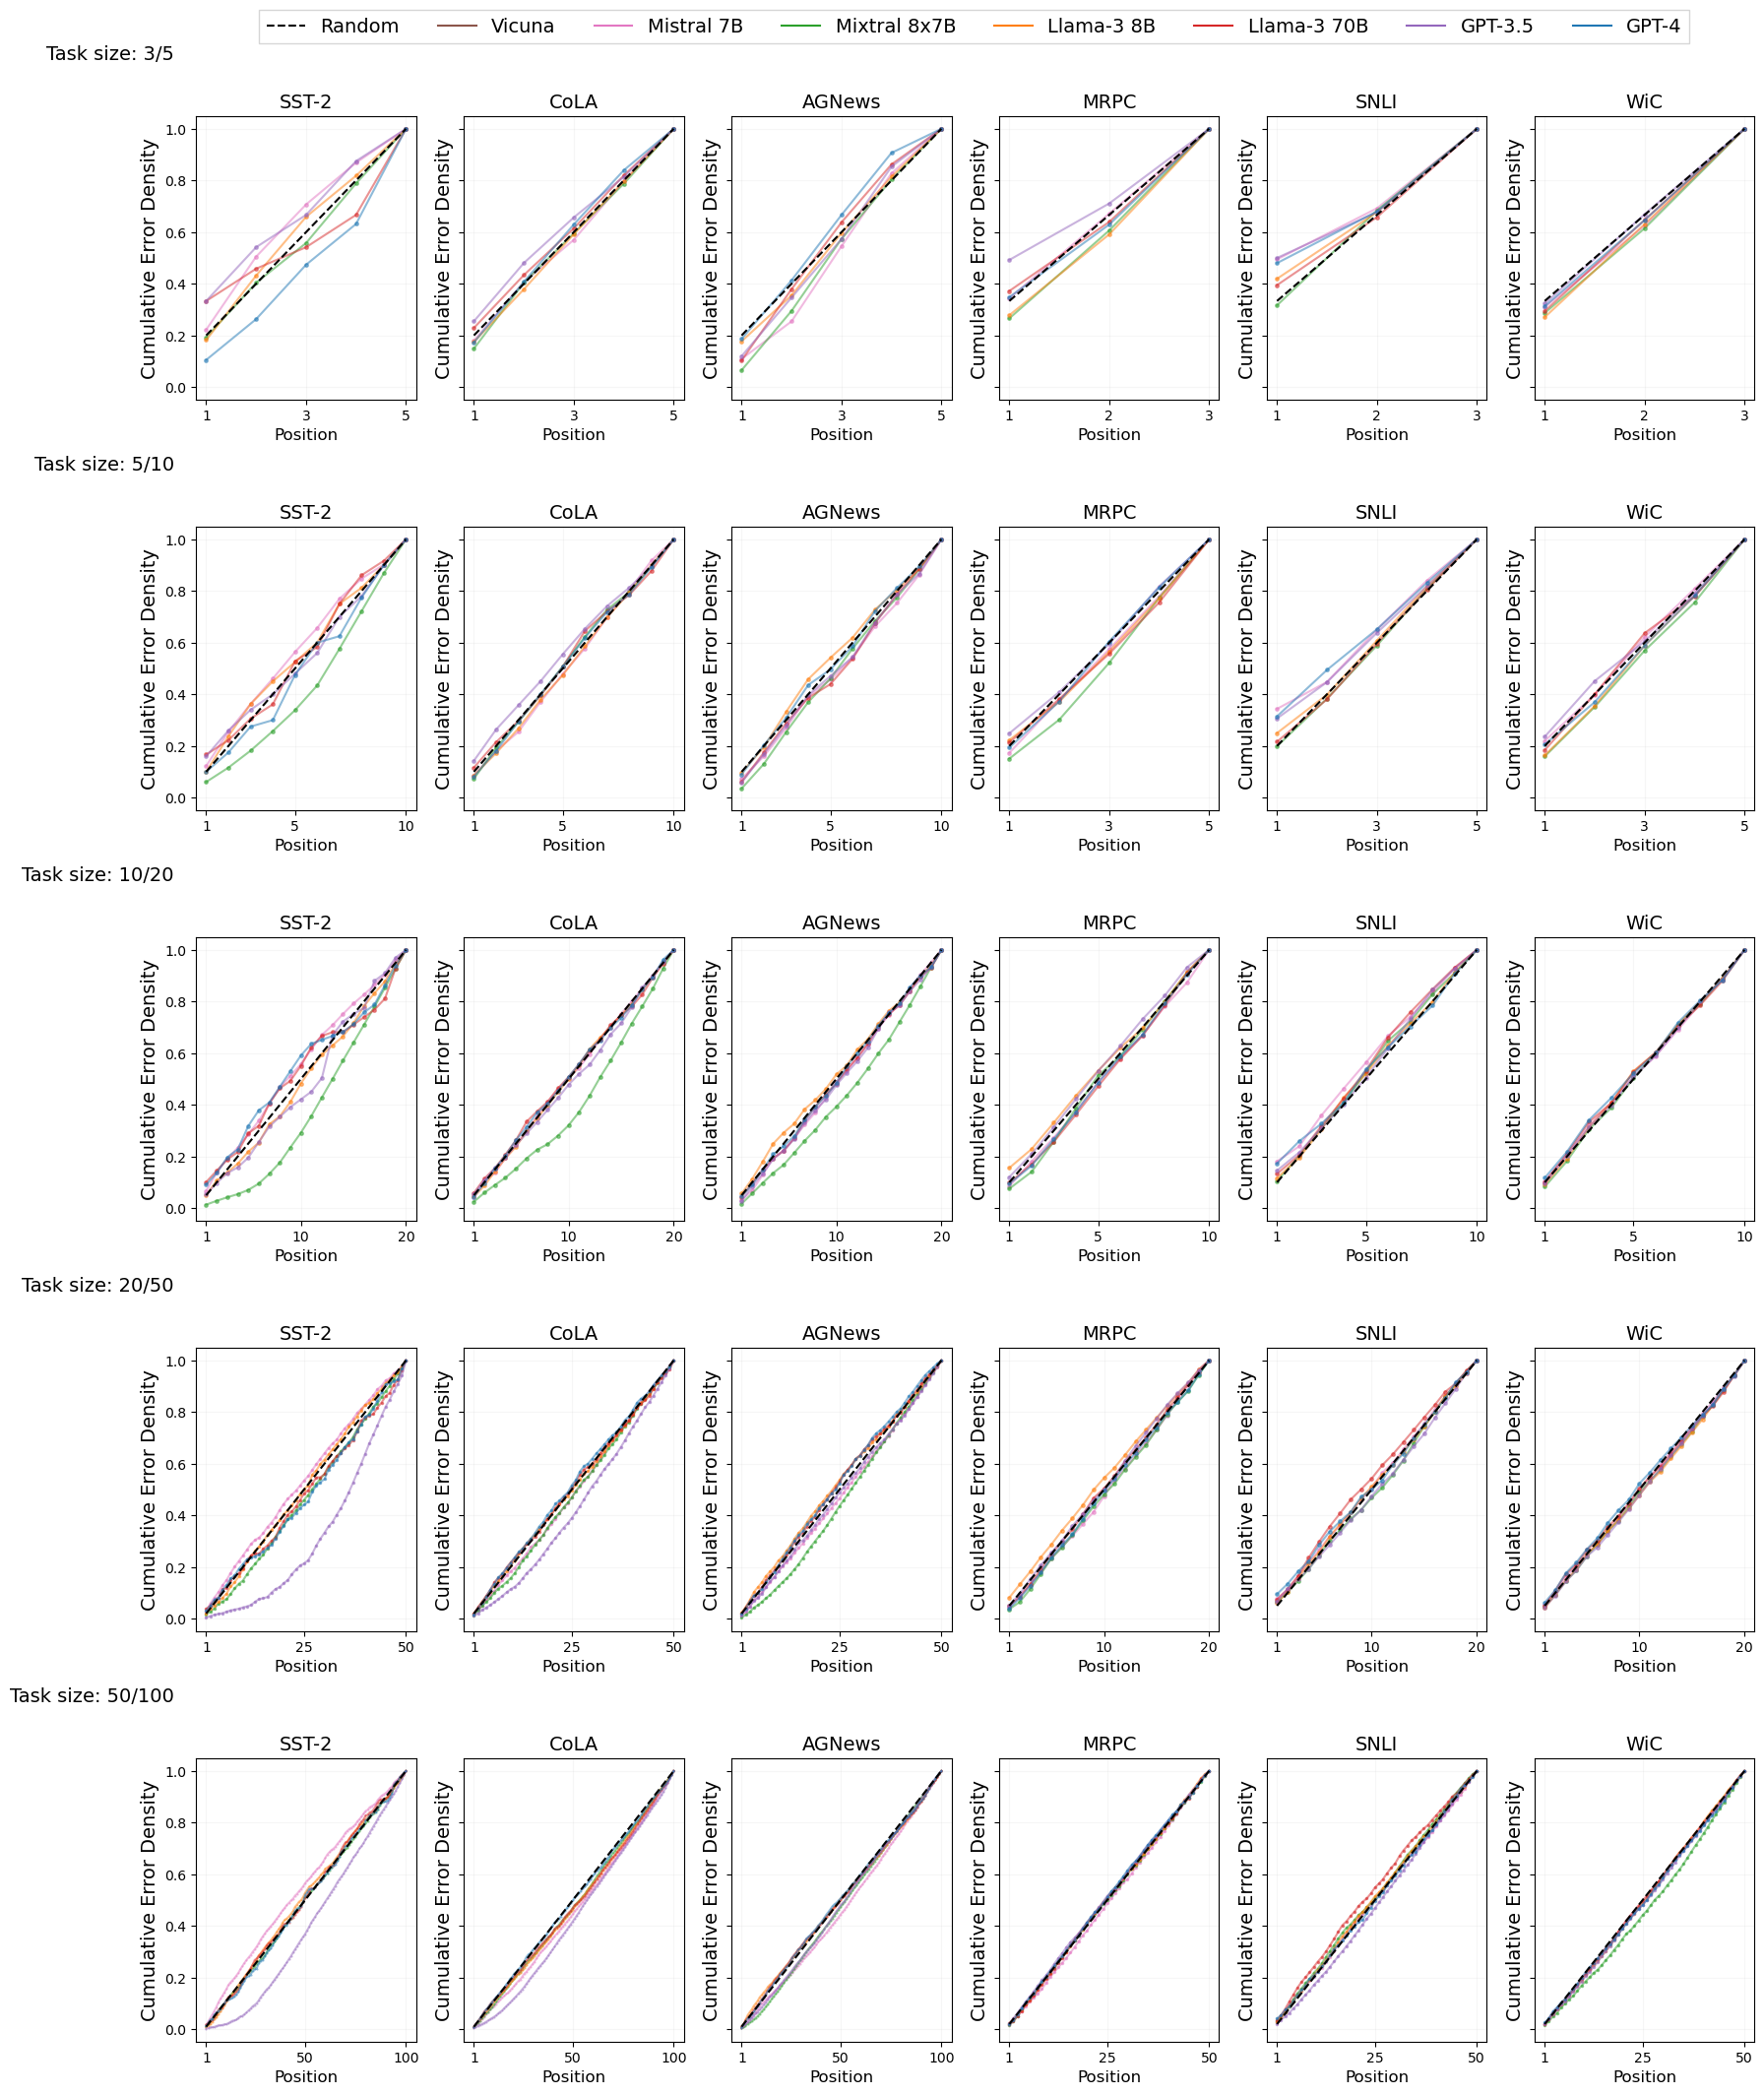

In [47]:
fig, axs = plt.subplots(5, len(benchmarks), figsize=(18, 21), sharey=True)


for i, benchmark in enumerate(benchmarks):
    sub = error_pos_distributions[error_pos_distributions.benchmark == benchmark]

    for j, taskSize in enumerate(sorted(sub.taskSize.unique())):
        ax = axs[j, i]

        subsub = sub[sub.taskSize == taskSize]
        xs = list(range(1, taskSize+1))

        if taskSize <= 20:
            markersize = 5
        elif taskSize == 50:
            markersize = 3
        else:
            markersize = 1
        
        for model in models[1:]:
            if model not in subsub.model.unique():
                continue
            
            subsubsub = subsub[subsub.model == model]
            error_dist = subsubsub["errorDistribution"].values[0]

            ys = []
            prev_y = 0
            for x in xs:
                y = error_dist.get(x, 0)
                y += prev_y
                prev_y = y
                ys.append(y)

            ax.plot(xs, ys, color=model2color[model], linestyle="-", 
                    marker=".", markersize=markersize, alpha=0.5)
            
        ax.plot([1, taskSize], [1/taskSize, 1], label="Random", color="black", linestyle="--")
        
        if i == 0:
            if taskSize in [3,5]:
                task_size = "3/5"
            elif taskSize == 10:
                task_size = "5/10"
            elif taskSize == 20:
                task_size = "10/20"
            elif taskSize == 50:
                task_size = "20/50"
            elif taskSize == 100:
                task_size = "50/100"

            ax.text(-0.1, 1.25, f"Task size: {task_size}", transform=ax.transAxes, 
                    fontsize=14, va='top', ha='right')

        ax.set_title(benchmark, fontsize=14)
        ax.set_xlabel("Position", fontsize=12)
        ax.set_ylabel("Cumulative Error Density", fontsize=14)

        if len(xs) == 3:
            ax.set_xticks([1, 2, 3])
        elif len(xs) == 5:
            ax.set_xticks([1, 3, 5])
        elif len(xs) == 10:
            ax.set_xticks([1, 5, 10])
        elif len(xs) == 20:
            ax.set_xticks([1, 10, 20])
        elif len(xs) == 50:
            ax.set_xticks([1, 25, 50])
        elif len(xs) == 100:
            ax.set_xticks([1, 50, 100])

        ax.grid(True, alpha=0.1)


for model in models:
    ax.plot([], [], label=model, color=model2color[model], linestyle="-")
    
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-2.55, 7.2), fancybox=False, shadow=False, ncol=8, fontsize=14)
plt.savefig("plots/full_res_cumulative_err.png", bbox_inches='tight', dpi=300)
plt.show()

## Follow-up results

In [48]:
follow_ups_details = pd.read_json("results/follow_up_results_all_details.json", lines=True)
follow_ups_stats = pd.read_csv("results/follow_up_results_statistics.csv")


for df in [follow_ups_details, follow_ups_stats]:
    df["model"] = df["model"].map(model_renamer)

del df

In [49]:
follow_ups_stats.benchmark.unique()

array(['AGNews-simplified_index_selection_only', 'SST-2', 'CoLA',
       'AGNews', 'MRPC', 'SNLI', 'WiC', 'CoLA_2_shot', 'SST-2-inference'],
      dtype=object)

### 1. Simplified Index Selection

In [99]:
ori_index_select_stats = main_results_stats.copy()[(main_results_stats.benchmark == "AGNews") & 
                                                   (main_results_stats.task.isin(["BatchClf", "SelectOne", "SelectAll"]))]

sim_index_select_stats = follow_ups_stats.copy()[follow_ups_stats.benchmark == "AGNews-simplified_index_selection_only"]
sim_index_select_stats = sim_index_select_stats[~((sim_index_select_stats.model == "Vicuna") & 
                                                  (sim_index_select_stats.taskSize == 100))]

index_select_stats = pd.concat([ori_index_select_stats, sim_index_select_stats]).reset_index(drop=True)
index_select_stats.benchmark = index_select_stats.benchmark.map({"AGNews": "AGNews", 
                                                                 "AGNews-simplified_index_selection_only": "AGNews (Simplified)"})

In [100]:
main_results = []
cols = ["benchmark", "task", "taskSize", "accuracy"]
tasks = ["BatchClf", "SelectOne", "SelectAll"]

for benchmark in ["AGNews", "AGNews (Simplified)"]:
    sub = index_select_stats.copy()[index_select_stats.benchmark == benchmark]
    for task in tasks:
        subsub = sub.copy()[sub.task == task]
        for taskSize in sorted(subsub.taskSize.unique()):
            subsubsub = subsub.copy()[subsub.taskSize == taskSize]
            acc = subsubsub["performance"].mean()
            main_results.append([benchmark, task, taskSize, acc])

main_results_df = pd.DataFrame(main_results, columns=cols)
main_results_df_pv = main_results_df.pivot(index=["benchmark", "taskSize"], columns="task", values="accuracy")
main_results_df_pv = main_results_df_pv.loc[["AGNews", "AGNews (Simplified)"]]
main_results_df_pv = main_results_df_pv.round(3)
main_results_df_pv = main_results_df_pv * 100
main_results_df_pv = main_results_df_pv.astype(float)
main_results_df_pv[tasks]

task                          BatchClf  SelectOne  SelectAll
benchmark           taskSize                                
AGNews              5             79.3       43.5       60.5
                    10            79.9       48.7       62.4
                    20            77.2       44.2       57.3
                    50            73.5       34.8       42.3
                    100           71.5       29.7       35.2
AGNews (Simplified) 5              NaN       77.3       78.0
                    10             NaN       82.0       87.3
                    20             NaN       85.4       89.6
                    50             NaN       78.3       79.6
                    100            NaN       82.6       75.7

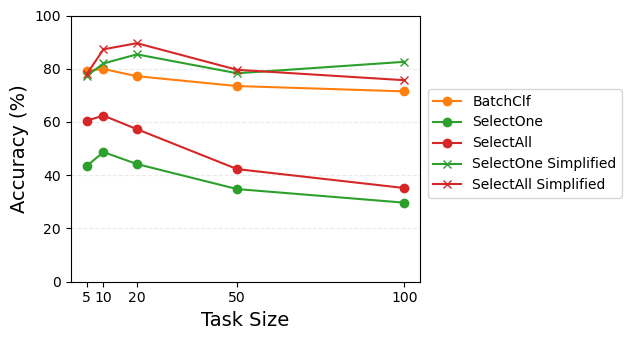

In [101]:
plt.figure(figsize=(7, 3.5))

for benchmark in ["AGNews", "AGNews (Simplified)"]:
    for task in tasks:
        sub = main_results_df.copy()[(main_results_df.benchmark == benchmark) & (main_results_df.task == task)]

        if len(sub) == 0:
            continue

        taskSizes = sorted(sub.taskSize.unique())

        accus = []
        for taskSize in taskSizes:
            subsub = sub.copy()[sub.taskSize == taskSize]
            acc = subsub["accuracy"].values[0]
            accus.append(round(acc, 3) * 100)
        
        if "Simplified" in benchmark:
            suffix = " Simplified"
            marker = 'x'
        else:
            suffix = ""
            marker = 'o'
        plt.plot(taskSizes, accus, label=task+suffix, marker=marker, color=task2color[task])

plt.ylim(0, 100)
plt.xticks(taskSizes)
plt.xlabel("Task Size", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.75))
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig("plots/simplified-index-selection-results.png", dpi=300)
plt.show()

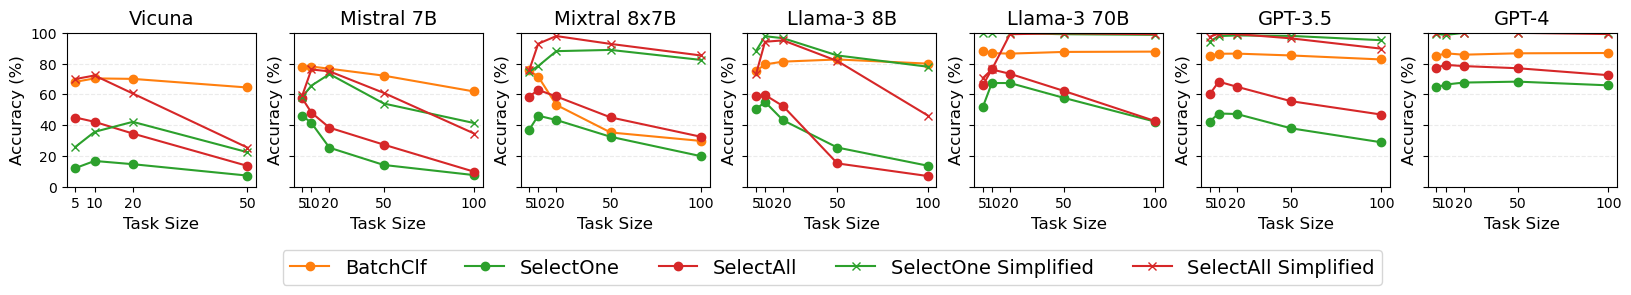

In [102]:
fig, axs = plt.subplots(1, 7, figsize=(20, 2), sharey=True)

for i, model in enumerate(models):
    ax = axs[i]

    for benchmark in ["AGNews", "AGNews (Simplified)"]:
        for task in tasks:
            sub = index_select_stats.copy()[(index_select_stats.model == model) & 
                                            (index_select_stats.task == task) & 
                                            (index_select_stats.benchmark == benchmark)]
        
            if len(sub) == 0:
                continue

            taskSizes = sorted(sub.taskSize.unique())
            accus = []
            for taskSize in taskSizes:
                subsub = sub.copy()[sub.taskSize == taskSize]
                acc = subsub["performance"].mean()
                accus.append(round(acc, 3) * 100)
            
            if "Simplified" in benchmark:
                suffix = " Simplified"
                marker = 'x'
            else:
                suffix = ""
                marker = 'o'
            ax.plot(taskSizes, accus, label=task+suffix, marker=marker, color=task2color[task])
            ax.set_title(model, fontsize=14)
            ax.set_ylim(0, 100)
            ax.set_xticks(taskSizes)
            ax.set_xlabel("Task Size", fontsize=12)
            ax.set_ylabel("Accuracy (%)", fontsize=12)         
            ax.grid(axis='y', linestyle='--', alpha=0.25)
               
plt.legend(loc='upper center', bbox_to_anchor=(-3.15, -0.35), ncol=5, fontsize=14)
# plt.tight_layout()
plt.savefig("plots/simplified-index-selection-full-results.png", bbox_inches='tight', dpi=300)
plt.show()

### 2. 1-shot-CoT

In [103]:
ori_stats = main_results_stats.copy()[(main_results_stats.task.isin(["BatchClf", "SelectOne", "SelectAll"])) & 
                                      (main_results_stats.taskSize == 10)]
CoT_stats = follow_ups_stats.copy()[follow_ups_stats.CoT]
CoT_stats.task = CoT_stats.task.apply(lambda x: x + " CoT")
CoT_stats = pd.concat([CoT_stats, ori_stats]).reset_index(drop=True)
CoT_stats = CoT_stats.sort_values(by="task", key=lambda x: x.map({"BatchClf": 1, "SelectOne": 2, "SelectOne CoT": 3, 
                                                                  "SelectAll": 4, "SelectAll CoT": 5})).reset_index(drop=True)
CoT_stats = CoT_stats.sort_values(by="benchmark", key=lambda x: x.map({"SST-2": 1, "CoLA": 2, "AGNews": 3, 
                                                                       "MRPC": 4, "SNLI": 5, "WiC": 6})).reset_index(drop=True)

In [104]:
CoT_stats[(CoT_stats.model == "GPT-4") & (CoT_stats.benchmark != "MRPC")]

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance
3,SST-2,BatchClf,10,GPT-4,False,0,1.0,0.960
6,SST-2,SelectOne,10,GPT-4,False,0,1.0,0.886
12,SST-2,SelectAll,10,GPT-4,False,0,1.0,0.924
20,SST-2,SelectOne CoT,10,GPT-4,True,1,1.0,0.848
24,SST-2,SelectAll CoT,10,GPT-4,True,1,1.0,0.913
35,CoLA,SelectOne CoT,10,GPT-4,True,1,1.0,0.820
37,CoLA,SelectAll,10,GPT-4,False,0,1.0,0.840
45,CoLA,SelectOne,10,GPT-4,False,0,1.0,0.808
48,CoLA,BatchClf,10,GPT-4,False,0,1.0,0.840
66,CoLA,SelectAll CoT,10,GPT-4,True,1,1.0,0.837


In [105]:
def get_overall_results_pv(benchmarks):
    overall_results = []
    cols = ["model", "task", "accuracy"]
    tasks = ["SelectOne", "SelectOne CoT", "SelectAll", "SelectAll CoT", "BatchClf"]

    for task in tasks:
        sub = CoT_stats.copy()[(CoT_stats.task == task) & (CoT_stats.benchmark.isin(benchmarks))]
        overall_results.append(["Overall", task, sub["performance"].mean()])
        
    models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
              "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]
    for model in models:
        sub = CoT_stats.copy()[(CoT_stats.model == model) & (CoT_stats.benchmark.isin(benchmarks))]
        for task in tasks:
            subsub = sub.copy()[sub.task == task]
            acc = subsub["performance"].mean()
            overall_results.append([model, task, acc])

    models = models + ["Overall"]
    overall_results_df = pd.DataFrame(overall_results, columns=cols)
    overall_results_df = overall_results_df.pivot(index="model", columns="task", values="accuracy")
    overall_results_df = overall_results_df.loc[models]
    overall_results_df = overall_results_df.round(3)
    overall_results_df = overall_results_df * 100
    overall_results_df = overall_results_df.astype(float)
    
    return overall_results_df[tasks]

In [106]:
overall_results_df = get_overall_results_pv(benchmarks).dropna()
overall_results_df

task,SelectOne,SelectOne CoT,SelectAll,SelectAll CoT,BatchClf
model,,,,,
Vicuna,23.0,25.8,53.2,57.6,68.7
Mistral 7B,38.3,47.2,56.8,60.5,71.2
Mixtral 8x7B,47.4,38.8,65.1,58.4,73.4
Llama-3 8B,39.0,41.9,62.4,59.0,73.3
Llama-3 70B,59.4,67.4,72.9,79.2,79.4
GPT-3.5,45.9,47.7,66.7,66.3,71.9
GPT-4,66.3,71.9,78.8,81.8,81.9
Overall,45.6,48.7,65.1,66.1,74.3


### 3. CoLA 2 shot

In [107]:
CoLA_ori_5 = main_results_stats.copy()[(main_results_stats.benchmark == "CoLA") & 
                                       (main_results_stats.taskSize <= 5)]
CoLA_fs = follow_ups_stats.copy()[follow_ups_stats.benchmark == "CoLA_2_shot"]

sub_5 = pd.concat([CoLA_ori_5, CoLA_fs]).reset_index(drop=True)

In [108]:
overall = []
for benchmark in ["CoLA_2_shot", "CoLA"]:
    subsub = sub_5.copy()[sub_5.benchmark == benchmark]
    for task in ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]:
        subsubsub = subsub[subsub.task == task]
        performance = subsubsub.performance.mean()
        taskSize = int(subsubsub.taskSize.mean())

        overall.append([benchmark, task, taskSize, "Overall", False, 0, "-", performance])

sub_5 = pd.concat([sub_5, pd.DataFrame(overall, columns=sub_5.columns)]).reset_index(drop=True)
sub_5_pivot = sub_5.pivot(index=["model", "benchmark"], columns="task", values="performance")[tasks].round(3)*100

In [91]:
sub_5_pivot.sort_index(level=0, key=lambda x: x.map({"Vicuna": 1, "Mistral 7B": 2, "Mixtral 8x7B": 3, 
                                                           "Llama-3 8B": 4, "Llama-3 70B": 5, "GPT-3.5": 6, 
                                                           "GPT-4": 7, "Overall": 8}), inplace=True)
sub_5_pivot

task                      BatchClf  SelectOne  SelectAll
model        benchmark                                  
Vicuna       CoLA             71.0       11.6       59.6
             CoLA_2_shot      50.4       13.2       64.0
Mistral 7B   CoLA             74.4       52.2       59.4
             CoLA_2_shot      65.0        9.6       60.4
Mixtral 8x7B CoLA             81.2       52.2       70.6
             CoLA_2_shot      73.2       11.2       72.4
Llama-3 8B   CoLA             79.4       44.8       61.2
             CoLA_2_shot      46.6        0.4       63.8
Llama-3 70B  CoLA             83.4       75.0       79.6
             CoLA_2_shot      82.0       28.8       80.8
GPT-3.5      CoLA             79.6       67.0       76.2
             CoLA_2_shot      76.8       42.6       72.8
GPT-4        CoLA             83.8       81.0       83.6
             CoLA_2_shot      80.8       49.8       81.0
Overall      CoLA             79.0       54.8       70.0
             CoLA_2_shot      67.8       22.2       70.7

### 4. SST-2 Inference

In [110]:
sst2_inf_stats = follow_ups_stats.copy()[follow_ups_stats.benchmark == "SST-2-inference"]

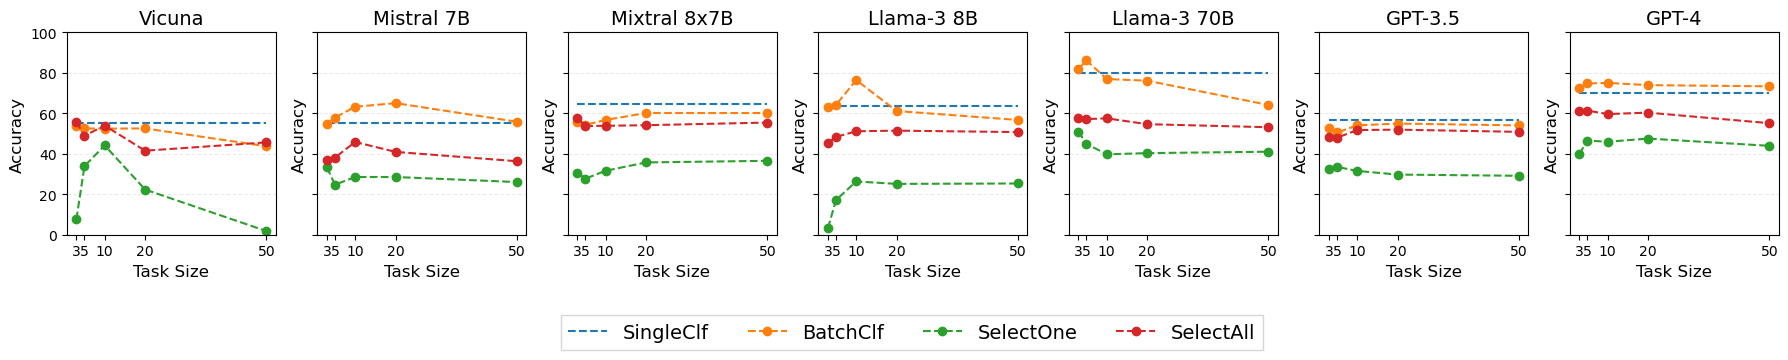

In [111]:
tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]
fig, axs = plt.subplots(1, 7, figsize=(18, 3), sharey=True)

for i, model in enumerate(models):
    sub = sst2_inf_stats.copy()[sst2_inf_stats.model == model]
    ax = axs[i]
    taskSizes = sorted(sub.taskSize.unique())[1:]
    num_sizes = len(taskSizes)

    for task in tasks:
        subsub = sub.copy()[sub.task == task]
        
        if task == "SingleClf":
            acc = round(subsub["performance"].mean(), 3) * 100
            ax.plot(taskSizes, [acc] * num_sizes, label=task, linestyle="--", color=task2color[task])
            
        else:
            accus = []
            for taskSize in taskSizes:
                subsubsub = subsub.copy()[subsub.taskSize == taskSize]
                acc = subsubsub["performance"].mean()
                accus.append(round(acc, 3) * 100)

            ax.plot(taskSizes, accus, label=task, marker='o', linestyle="--", color=task2color[task])

    ax.set_title(model, fontsize=14)
    ax.set_xlabel("Task Size", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    
    ax.set_ylim(0, 100)
    ax.set_xticks(taskSizes)
    
plt.tight_layout()
# plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(-3.15, -0.35), fancybox=False, shadow=False, ncol=4, fontsize=14)
plt.savefig("plots/sst-2-inf-results.png",  bbox_inches='tight', dpi=300)
plt.show()